## CS610: Applied Machine Learning Project

This notebook serves to detail our workflow and code on our project objective of building an image classification model to fulfil the business objective of identifying different shoe models. The dataset can be found in the repository and is sourced from Kaggle <br>(<i>**state source?**</i>).

### Install and import packages

In [6]:
!pip install opencv-python torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 10.9 MB/s eta 0:00:00a 0:00:01


In [1]:
# import cudf
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import os
import tqdm
import xgboost as xgb
import time
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score
import torch
from torch import nn, optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Running On CPU, Please skip this cell
import cuml
print(cuml.__version__)
from cuml.model_selection import train_test_split
from cuml.metrics import accuracy_score
%load_ext cuml.accel

25.06.00
cuML: Accelerator installed.


## Check Data Source

In [4]:
def count_images(datasource_path):
    image_counts = {}
    image_extensions = {'.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff', '.webp'}

    if not os.path.isdir(datasource_path):
        print(f"Error: Path '{datasource_path}' is not a directory.")
        return image_counts

    for subfolder_name in os.listdir(datasource_path):
        subfolder_path = os.path.join(datasource_path, subfolder_name)

        if os.path.isdir(subfolder_path):
            count = 0
            for file_name in os.listdir(subfolder_path):
                file_path = os.path.join(subfolder_path, file_name)
                if os.path.isfile(file_path):
                    _, ext = os.path.splitext(file_name)
                    if ext.lower() in image_extensions:
                        count += 1
            image_counts[subfolder_name] = count
    return image_counts

image_dir = 'datasource'
print(f"Scanning: {image_dir}")
counts = count_images(image_dir)

if counts:
    for folder, count in counts.items():
        print(f"{folder}: {count} images")
else:
    print("No images found or path is incorrect/empty.")
# else:

Scanning: datasource
adidas_forum_high: 150 images
adidas_forum_low: 115 images
adidas_gazelle: 149 images
adidas_nmd_r1: 115 images
adidas_samba: 115 images
adidas_stan_smith: 147 images
adidas_superstar: 115 images
adidas_ultraboost: 150 images
asics_gel-lyte_iii: 91 images
converse_chuck_70_high: 115 images
converse_chuck_70_low: 148 images
converse_chuck_taylor_all-star_high: 114 images
converse_chuck_taylor_all-star_low: 114 images
converse_one_star: 150 images
new_balance_327: 108 images
new_balance_550: 150 images
new_balance_574: 150 images
new_balance_990: 113 images
new_balance_992: 150 images
nike_air_force_1_high: 115 images
nike_air_force_1_low: 147 images
nike_air_force_1_mid: 148 images
nike_air_jordan_11: 113 images
nike_air_jordan_1_high: 115 images
nike_air_jordan_1_low: 115 images
nike_air_jordan_3: 100 images
nike_air_jordan_4: 150 images
nike_air_max_1: 106 images
nike_air_max_270: 149 images
nike_air_max_90: 150 images
nike_air_max_95: 115 images
nike_air_max_97: 

## Data Augmentation

Data Augmentation in image classification can improve the performance and robustness of the models.  
More Detailly, it has the following benefits.  
1. preventing overfitting
2. increasing dataset size and diversity
3. improve generalisation capabilities
4. enhancing model robustness
5. address class imbalance


**Common Data Augmentation Techniques for Images**  
1. Geometric Transformations:
    a. Flipping  
    b. Rotation  
    c. Cropping  
2. Photometric Transformations:
    a. Brightness Adjustment  
    b. Contrast Adjustment  
    c. Saturation Adjustment  
    d. Hue Adjustment  
    c. Grayscaling  
3. Noise Injection
4. Random Erasing

In our project, we are building models to identify sneakers by uploaded the full image for sneakers.  
To improve the robustness based on our needs, we adopted three techniques - flipping, rotation and brightness adjustment.

In [5]:
def image_augmentation(image, augmentation_type,angle_range=(-15, 15), brightness_range=(0.7, 1.3)):
    if augmentation_type == 'flip':
        return cv2.flip(image, 1)
    elif augmentation_type == 'rotate':
        angle = np.random.randint(angle_range[0], angle_range[1] + 1)
        (h, w) = image.shape[:2]
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        return cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT)
    elif augmentation_type == 'brightness':
        brightness_factor = np.random.uniform(brightness_range[0], brightness_range[1])
        return np.clip(image * brightness_factor, 0, 255).astype(np.uint8)
    return image # return orginal image

In [6]:
# Create a directory to store the augmented images
aug_dir = 'augmented_images'
os.makedirs(aug_dir, exist_ok = True)

all_images_paths = []
all_images_labels = []



sneaker_names_list = os.listdir(image_dir)
print("====== Image Augmentation Starts ======")
for sneaker_name in tqdm.tqdm(sneaker_names_list, desc="Augmenting"):
    original_path = os.path.join(image_dir, sneaker_name)
    if os.path.isdir(original_path):
        aug_path = os.path.join(aug_dir, sneaker_name)
        os.makedirs(aug_path, exist_ok = True)
        
        for image in os.listdir(original_path):

            # design saved path
            # 1. orinal
            image_full_path = os.path.join(original_path, image)
            original_image = cv2.imread(image_full_path)
            if original_image is None:
                print(f'WARNING: CANNOT READ IMAGE {image_full_path}, SKIPPED!')
                continue
            
            base, ext = os.path.splitext(image)

            # design saved path
            # 1. orinal
            image_name_original = f'{base}_original{ext}'
            original_image_saved_path = os.path.join(aug_path,image_name_original)
            # 2. flipped
            image_name_flipped = f'{base}_flipped{ext}'
            flipped_image_saved_path = os.path.join(aug_path,image_name_flipped)
            # 3. rotated
            image_name_rotated = f'{base}_rotated{ext}'
            rotated_image_saved_path = os.path.join(aug_path,image_name_rotated)
            # 4. bright
            image_name_brightened = f'{base}_brightened{ext}'
            brightened_image_saved_path = os.path.join(aug_path,image_name_brightened)

            # augmentation operations
            # 1. original
            cv2.imwrite(original_image_saved_path, original_image)
            all_images_paths.append(original_image_saved_path)
            all_images_labels.append(sneaker_name)

            # 2. flipped
            img_flipped = image_augmentation(original_image, augmentation_type = 'flip')
            cv2.imwrite(flipped_image_saved_path, img_flipped)
            all_images_paths.append(flipped_image_saved_path)
            all_images_labels.append(sneaker_name)

            # 3. rotated
            img_rotated = image_augmentation(original_image, augmentation_type = 'rotate')
            cv2.imwrite(rotated_image_saved_path, img_rotated)
            all_images_paths.append(rotated_image_saved_path)
            all_images_labels.append(sneaker_name)

            # 4. brightness
            img_bright = image_augmentation(original_image, augmentation_type = 'brightness')
            cv2.imwrite(brightened_image_saved_path, img_bright)
            all_images_paths.append(brightened_image_saved_path)
            all_images_labels.append(sneaker_name)

print("====== Image Augmentation Starts ======")

image_df_augmented = pd.DataFrame({
    'path': all_images_paths,
    'label': all_images_labels
})

print(f"We have now {len(image_df_augmented)} images for modelling")

image_df_augmented

====== Image Augmentation Starts ======


Augmenting:  12%|█▏        | 6/50 [00:10<01:22,  1.88s/it]

Augmenting:  46%|████▌     | 23/50 [00:45<01:48,  4.03s/it]

Augmenting: 100%|██████████| 50/50 [01:54<00:00,  2.28s/it]

====== Image Augmentation Starts ======
We have now 25920 images for modelling


,path,label
0,augmented_images\adidas_forum_high\0001_origin...,adidas_forum_high
1,augmented_images\adidas_forum_high\0001_flippe...,adidas_forum_high
2,augmented_images\adidas_forum_high\0001_rotate...,adidas_forum_high
3,augmented_images\adidas_forum_high\0001_bright...,adidas_forum_high
4,augmented_images\adidas_forum_high\0002_origin...,adidas_forum_high
...,...,...
25915,augmented_images\yeezy_slide\0144_brightened.jpg,yeezy_slide
25916,augmented_images\yeezy_slide\0145_original.jpg,yeezy_slide
25917,augmented_images\yeezy_slide\0145_flipped.jpg,yeezy_slide
25918,augmented_images\yeezy_slide\0145_rotated.jpg,yeezy_slide


In [8]:
image_df_augmented.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25920 entries, 0 to 25919
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    25920 non-null  object
 1   label   25920 non-null  object
dtypes: object(2)
memory usage: 405.1+ KB


## Image Processing

### Resizing

In [9]:
# resize images
def resize_image_in_folder(input_dir, output_dir, size=(224, 224), desc='resizing images'):
    if not os.path.exists(input_dir):
        print(f"Input directory {input_dir} does not exist. Please check the path.")
        return

    os.makedirs(output_dir, exist_ok=True)
    supported_formats = ('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff', '.webp')
    for filename in os.listdir(input_dir):
        if filename.lower().endswith(supported_formats):
            img_input_path = os.path.join(input_dir, filename)
            img_output_path = os.path.join(output_dir, filename)
            try:
                img = cv2.imread(img_input_path, cv2.IMREAD_UNCHANGED)

                if img is None:
                    print(f"Error loading {img_input_path}")
                    continue
                resized_img = cv2.resize(img, size, interpolation=cv2.INTER_LANCZOS4)

                if img_output_path.lower().endswith(('.jpg', '.jpeg')) and resized_img.shape[-1] == 4:
                    resized_img = cv2.cvtColor(resized_img, cv2.COLOR_BGRA2BGR)
                cv2.imwrite(img_output_path, resized_img)
            except Exception as e:
                print(f"Error processing {img_input_path}: {e}")

In [10]:
# process all folders
def batch_resize_images(base_input_dir, base_output_dir, size=(128, 128)):
    if not os.path.exists(base_input_dir):
        print(f"Base directory {base_input_dir} does not exist. Please check the path.")
        return

    os.makedirs(base_output_dir, exist_ok=True) # if output directory does not exist, create it.

    for folder in tqdm.tqdm(os.listdir(base_input_dir)):
        current_input_subfolder = os.path.join(base_input_dir, folder)
        current_output_subfolder = os.path.join(base_output_dir, folder)

        if os.path.isdir(current_input_subfolder):
            resize_image_in_folder(current_input_subfolder, current_output_subfolder, size=size)
        else:
            print(f"Skipping {current_input_subfolder} as it is not a directory.")

    print("Batch resizing completed.")

In [11]:
input_dir = '../CS610_AML_Group_Project/augmented_images'
output_dir = '../CS610_AML_Group_Project/resized_images'

In [12]:
batch_resize_images(input_dir, output_dir, size=(128, 128))

100%|██████████| 50/50 [05:53<00:00,  7.07s/it]

Batch resizing completed.


### Gray Scaling

In [ ]:
def grayscale_image_in_folder(input_dir, output_dir):
    if not os.path.exists(input_dir):
        print(f"Input directory {input_dir} does not exist. Please check the path.")
        return

    os.makedirs(output_dir, exist_ok=True)
    supported_formats = ('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff', '.webp')
    for filename in os.listdir(input_dir):
        if filename.lower().endswith(supported_formats):
            img_input_path = os.path.join(input_dir, filename)
            img_output_path = os.path.join(output_dir, filename)
            try:
                img = cv2.imread(img_input_path)
                if img is None:
                    print(f"Error loading {img_input_path}")
                    continue
                # Convert to grayscale
                gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                cv2.imwrite(img_output_path, gray_img)
            except Exception as e:
                print(f"Error processing {img_input_path}: {e}")

In [14]:
def batch_grayscale_images(base_input_dir, base_output_dir):
    if not os.path.exists(base_input_dir):
        print(f"Base directory {base_input_dir} does not exist. Please check the path.")
        return

    os.makedirs(base_output_dir, exist_ok=True)

    for folder in tqdm.tqdm(os.listdir(base_input_dir)):
        current_input_subfolder = os.path.join(base_input_dir, folder)
        current_output_subfolder = os.path.join(base_output_dir, folder)

        if os.path.isdir(current_input_subfolder):
            grayscale_image_in_folder(current_input_subfolder, current_output_subfolder)
        else:
            print(f"Skipping {current_input_subfolder} as it is not a directory.")

    print("Batch grayscale completed.")

In [15]:
base_input_dir = '../CS610_AML_Group_Project/resized_images'
base_output_dir = '../CS610_AML_Group_Project/grayscale_images'
batch_grayscale_images(base_input_dir, base_output_dir)

100%|██████████| 50/50 [04:57<00:00,  5.95s/it]

Batch grayscale completed.


## Feature extraction and Model Training
Feature extraction serves as an important part of the data processing step as the correct method used will help the models to learn the features better and hence produce higher accuracy. To investigate on which method is the better feature extraction method, two RandomForestClassifier models with the same set of parameters (found using RandomizedSearchCV previously) was used. The accuracy score will be used to determine which method is better for this use case.

### Pipeline Models using Feature Extraction Method 1 - By HOG

#### Feature Extraction by HOG

In [2]:
def extract_hog_features_recursive(input_dir, force_size = (128, 128), pixels_per_cell=(16, 16), cells_per_block=(2, 2)):
    features = []
    filenames = []
    supported_formats = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.webp')
    for root, dirs, files in tqdm.tqdm(os.walk(input_dir)):
        for filename in tqdm.tqdm(files):
            if filename.lower().endswith(supported_formats):
                img_path = os.path.join(root, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                # force resized in case feature extraction failed
                img_resized = cv2.resize(img, force_size, interpolation=cv2.INTER_AREA)
                # pixel normalisation
                img_normalised = img_resized.astype(np.float32) / 255.0
                # Extract HOG features
                try:
                    hog_feature = hog(img_normalised, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, feature_vector=True)
                    features.append(hog_feature)
                    rel_path = os.path.relpath(img_path, input_dir)
                    filenames.append(rel_path)
                except Exception as e:
                    print("WARNING: {img_path} Failed with HOG feature extraction!")
                    continue
    hogged = np.array(features)
    return hogged, filenames

# Example usage:
input_dir = '../CS610_AML_Group_Project/grayscale_images'
print('====== HOG Extraction Starts! ======')
hogged, filenames = extract_hog_features_recursive(input_dir)
print('====== HOG Extraction Completed! ======')
print(hogged.shape)  # (num_images, hog_feature_dim)

====== HOG Extraction Starts! ======


0it [00:00, ?it/s]
100%|██████████| 580/580 [00:05<00:00, 98.21it/s]
51it [04:01,  4.73s/it]


====== HOG Extraction Completed! ======
(25920, 1764)


In [3]:
print("====== Feature Matrix Check ======")
print(hogged)
print(f"Shape: {hogged.shape}")

====== Feature Matrix Check ======
[[0.16098824 0.         0.11383587 ... 0.01137023 0.00299632 0.        ]
 [0.08114031 0.03628705 0.06884983 ... 0.         0.         0.        ]
 [0.19807696 0.09491005 0.16007036 ... 0.00457401 0.         0.        ]
 ...
 [0.         0.         0.         ... 0.00290865 0.         0.        ]
 [0.11182898 0.         0.         ... 0.         0.         0.        ]
 [0.02163972 0.         0.09180957 ... 0.02596537 0.0046525  0.        ]]
Shape: (25920, 1764)


In [4]:
print("====== File Check ======")
print(filenames)

====== File Check ======
['adidas_forum_high\\0001_brightened.jpg', 'adidas_forum_high\\0001_flipped.jpg', 'adidas_forum_high\\0001_original.jpg', 'adidas_forum_high\\0001_rotated.jpg', 'adidas_forum_high\\0002_brightened.jpg', 'adidas_forum_high\\0002_flipped.jpg', 'adidas_forum_high\\0002_original.jpg', 'adidas_forum_high\\0002_rotated.jpg', 'adidas_forum_high\\0003_brightened.jpg', 'adidas_forum_high\\0003_flipped.jpg', 'adidas_forum_high\\0003_original.jpg', 'adidas_forum_high\\0003_rotated.jpg', 'adidas_forum_high\\0004_brightened.jpg', 'adidas_forum_high\\0004_flipped.jpg', 'adidas_forum_high\\0004_original.jpg', 'adidas_forum_high\\0004_rotated.jpg', 'adidas_forum_high\\0005_brightened.jpg', 'adidas_forum_high\\0005_flipped.jpg', 'adidas_forum_high\\0005_original.jpg', 'adidas_forum_high\\0005_rotated.jpg', 'adidas_forum_high\\0006_brightened.jpg', 'adidas_forum_high\\0006_flipped.jpg', 'adidas_forum_high\\0006_original.jpg', 'adidas_forum_high\\0006_rotated.jpg', 'adidas_forum_

In [5]:
#DO NOT RUN - save filenames and hogged for easier access (without needing to run hog function again)
np.savetxt("filename.csv", filenames, delimiter =",", fmt ='% s')
np.save("hogged.npy", hogged)

In [6]:
#get filenames
import csv
filenames = []
with open("./filename.csv", 'r', newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        filenames.extend(row)
len(filenames)

25920

In [7]:
#get hogged
hogged = np.load("hogged.npy")
hogged.shape

(25920, 1764)

In [8]:
#Labeling
y = [f.split(os.sep)[0] for f in filenames]
#split data into train_test split
x = hogged.astype(np.float32)
y = np.array(y)
y, uniques = pd.factorize(y)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)
x_train = pd.DataFrame(x_train, dtype=np.float32)
y_train = pd.Series(y_train, dtype=np.int32)
x_test = pd.DataFrame(x_test, dtype=np.float32)
y_test = pd.Series(y_test, dtype=np.int32)

In [9]:
#Check if data is prepared successfully
print("Number of Samples:", len(y_train))
print("Number of Labels:", len(np.unique(y_train)))
counts = y_train.value_counts()
print("Label Distribution:")
print(counts)

Number of Samples: 20736
Number of Labels: 50
Label Distribution:
15    480
37    480
16    480
0     480
13    480
18    480
29    480
26    480
36    480
7     480
45    477
33    477
28    477
2     477
21    474
10    474
48    473
41    473
39    473
43    473
42    470
20    470
5     470
49    464
35    368
31    368
40    368
9     368
3     368
32    368
24    368
30    368
1     368
38    368
46    368
19    368
4     368
6     365
12    365
23    365
11    365
44    362
17    362
22    362
47    346
14    346
34    342
27    339
25    320
8     291
Name: count, dtype: int64


#### Feature Standardisation

In [10]:
print("\n====== Feature Standardisation Started! ======")
scaler = StandardScaler()
scaler.fit(x_train) 

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

print("\n====== Feature Standardisation Completed! ======")
print(f"The Shape for Training Set after Feature Standardisation: {x_train_scaled.shape}")
print(f"The Shape for Testing Set after Feature Standardisation: {x_test_scaled.shape}")



====== Feature Standardisation Started! ======

====== Feature Standardisation Completed! ======
The Shape for Training Set after Feature Standardisation: (20736, 1764)
The Shape for Testing Set after Feature Standardisation: (5184, 1764)


#### Dimensionality Reduction by PCA

In [11]:
print("\n====== Dimensionality Reduction by PCA Started! ======")
pca = PCA(n_components=0.85, random_state=42) 
pca.fit(x_train_scaled)


x_train_pca = pca.transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)

print("\n====== Dimensionality Reduction by PCA Completed! ======")
print(f"The Shape for Training Set after Dimensionality Reduction by PCA: {x_train_pca.shape}")
print(f"The Shape for Testing Set after Dimensionality Reduction by PCA: {x_test_pca.shape}")
print(f"The Number of Chosen PCA: {pca.n_components_}")
print(f"The Explained Variance Ratio: {np.sum(pca.explained_variance_ratio_):.4f}")


====== Dimensionality Reduction by PCA Started! ======

====== Dimensionality Reduction by PCA Completed! ======
The Shape for Training Set after Dimensionality Reduction by PCA: (20736, 242)
The Shape for Testing Set after Dimensionality Reduction by PCA: (5184, 242)
The Number of Chosen PCA: 242
The Explained Variance Ratio: 0.8504


#### 1) RandomForestClassifier - feature extraction by hog

In [36]:
skip_train = True

if skip_train:
    # Import previous model
    print("Training skipped, importing model trained previously...")
    print("Fitted 3 folds for each of 30 candidates, totalling 30 fits")
    with open('model_bank/best_hog_rf_model.pkl', 'rb') as file:
        best_hog_rf = pickle.load(file)

else:
    start_time = time.time()

    # Base model
    base_model = RandomForestClassifier(random_state=42)

    # Hyperparameters
    param_dist = {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [10, 20, 30, 40],
        'max_features': ['sqrt', 'log2', 0.5, 0.8, 1.0]
    }

    # Randomized search tuning
    random_search = RandomizedSearchCV(
        base_model,
        param_dist,
        n_iter=10,
        scoring='accuracy',
        cv=3,
        verbose=2,
        random_state=42,
        error_score='raise',
        n_jobs=-1
    )
    random_search.fit(x_train_pca, y_train)

    # End timing
    end_time = time.time()
    training_time = end_time - start_time

Training skipped, importing model trained previously...
Fitted 3 folds for each of 30 candidates, totalling 30 fits


In [37]:
if skip_train:
    print("Training skipped, printing model trained previously...\n")
    print("Best Parameters: {'n_estimators': 150, 'max_features': 0.5, 'max_depth': 40}")
    print("Best Accuracy: 0.563416")
    training_time = 47.19
else:
    best_hog_rf = random_search.best_estimator_
    print("Best Parameters:", random_search.best_params_)
    print(f"Best Accuracy: {random_search.best_score_:.6f}")
    training_time = round(training_time /60, 2)
print(f"Total Training Time: {training_time} minutes")

Training skipped, printing model trained previously...

Best Parameters: {'n_estimators': 150, 'max_features': 0.5, 'max_depth': 40}
Best Accuracy: 0.563416
Total Training Time: 47.19 minutes


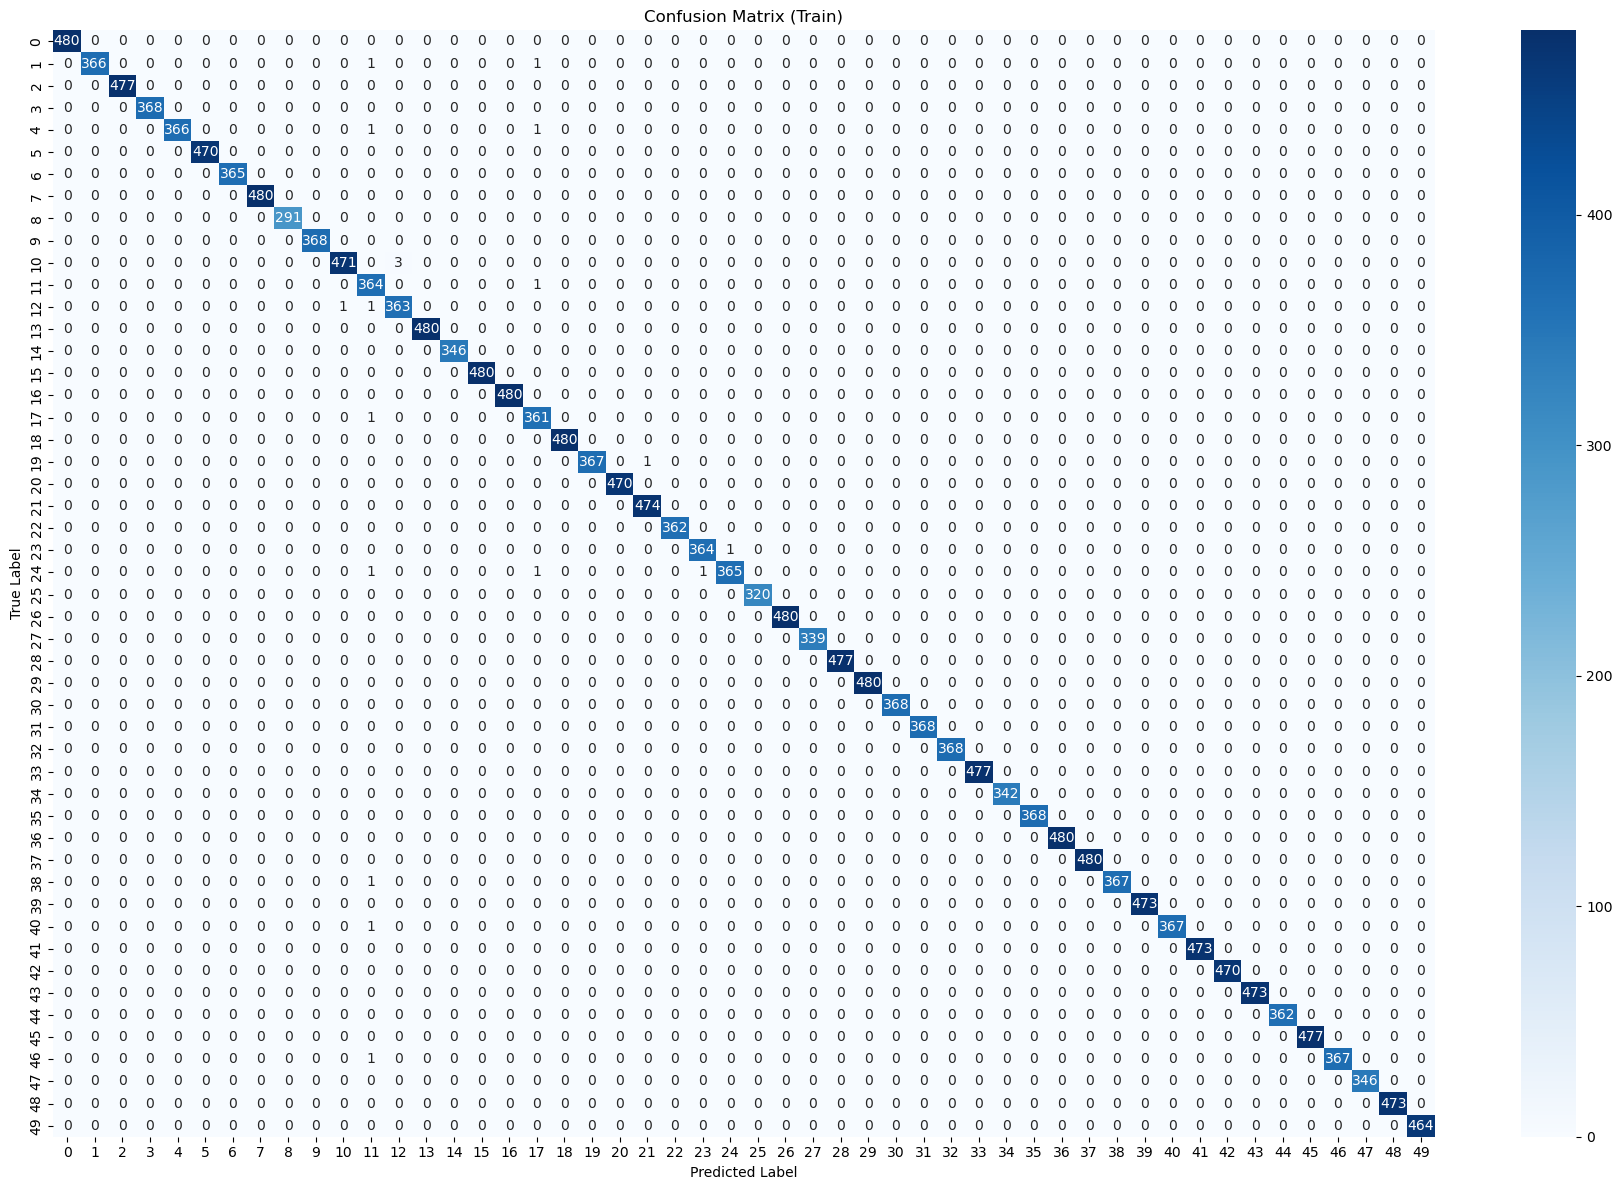

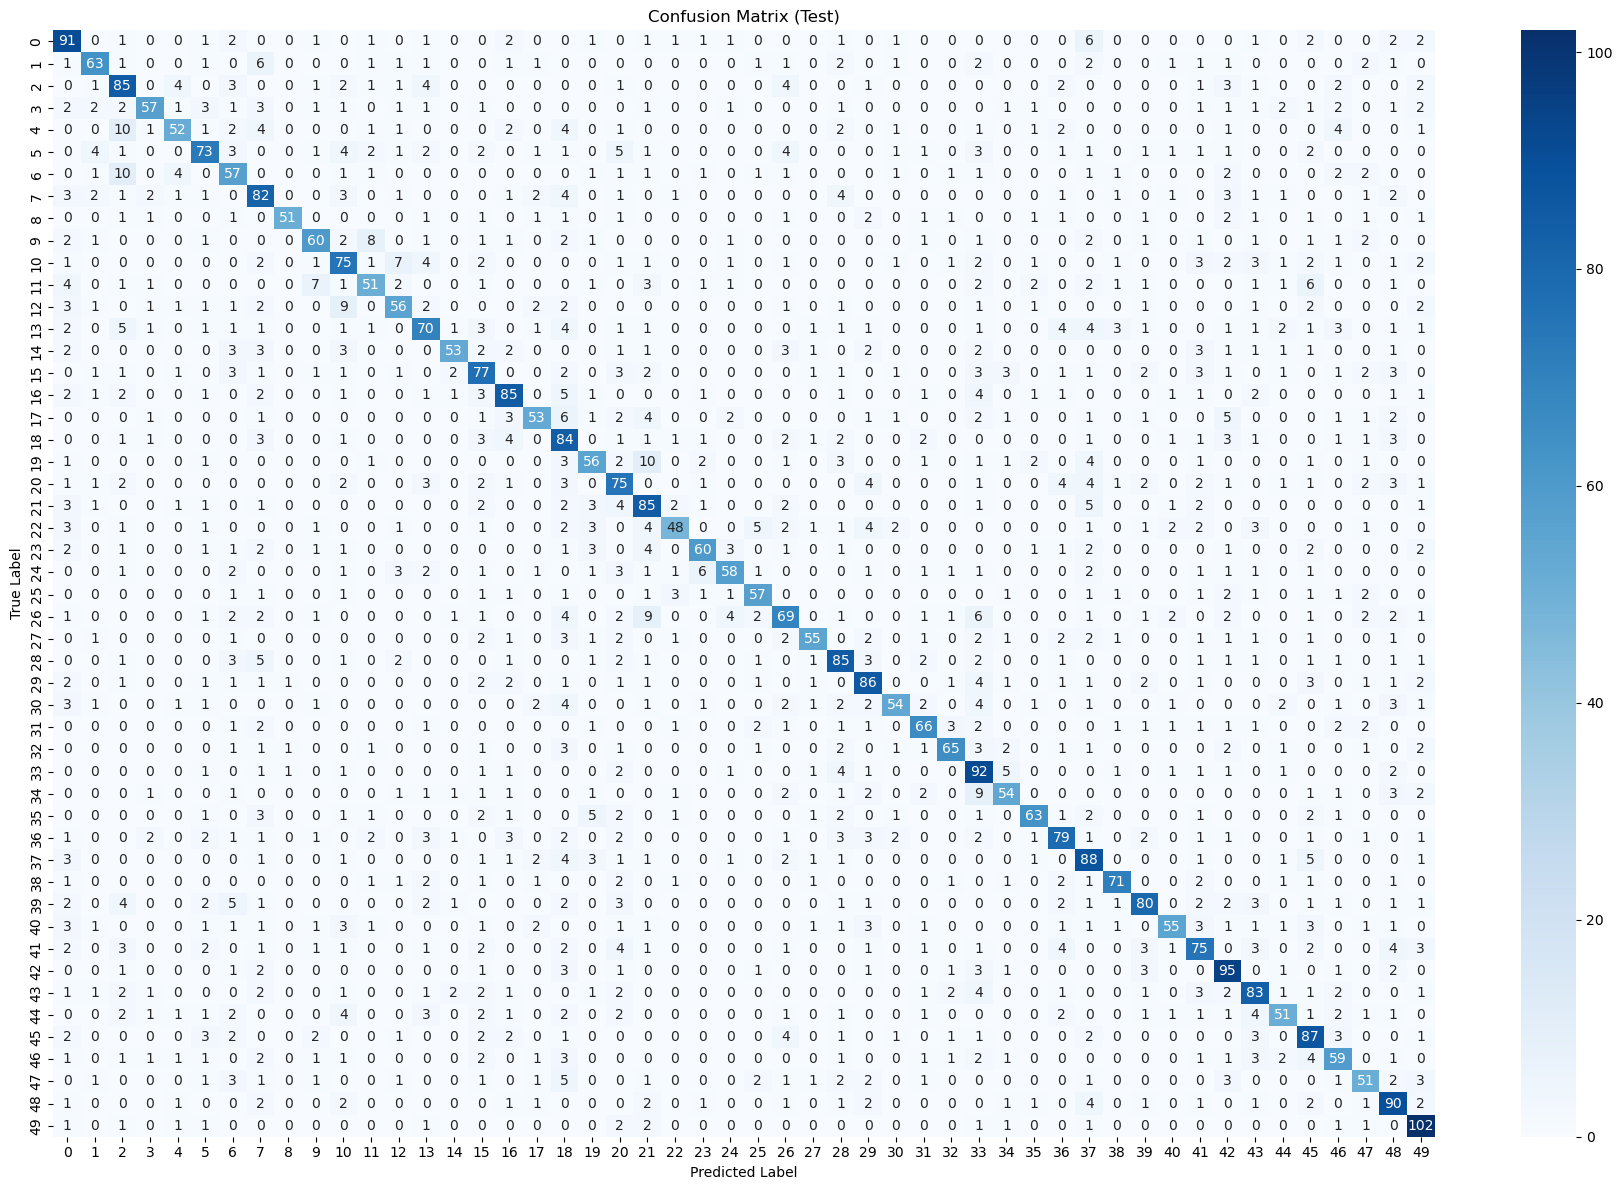

,Metric,Average Type,Train,Test
0,Training time (minutes),N/A,47.190000,N/A
1,Accuracy,N/A,0.999084,0.669174
2,Precision,macro,0.998993,0.690753
3,Precision,micro,0.999084,0.669174
4,Precision,weighted,0.999093,0.681727
5,Recall,macro,0.999001,0.665104
6,Recall,micro,0.999084,0.669174
7,Recall,weighted,0.999084,0.669174
8,F0.5-Score,macro,0.998993,0.681991
9,F0.5-Score,micro,0.999084,0.669174


In [38]:
# Predict
y_train_pred = best_hog_rf.predict(x_train_pca)
y_test_pred = best_hog_rf.predict(x_test_pca)

# Generate confusion matrix (train)
cm_train = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(18, 12))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Train)')
plt.tight_layout()
plt.show()

# Generate confusion matrix (test)
cm_train = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(18, 12))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test)')
plt.tight_layout()
plt.show()

# Function to save metrics
metrics = {"Metric": [], "Average Type": [], "Train": [], "Test": []}
def add_metric(name, avg_type, train_value, test_value):
    metrics["Metric"].append(name)
    metrics["Average Type"].append(avg_type)
    metrics["Train"].append(train_value)
    metrics["Test"].append(test_value)

# Training time
add_metric("Training time (minutes)", "N/A", training_time, "N/A")

# Accuracy
add_metric("Accuracy", "N/A",
           accuracy_score(y_train, y_train_pred),
           accuracy_score(y_test, y_test_pred))

# Precision
for avg in ['macro', 'micro', 'weighted']:
    add_metric("Precision", avg,
               precision_score(y_train, y_train_pred, average=avg),
               precision_score(y_test, y_test_pred, average=avg))

# Recall
for avg in ['macro', 'micro', 'weighted']:
    add_metric("Recall", avg,
               recall_score(y_train, y_train_pred, average=avg),
               recall_score(y_test, y_test_pred, average=avg))

# F0.5-Score 
beta = 0.5 # mis-labelled sneakers are more costly than missing labels
for avg in ['macro', 'micro', 'weighted']:
    add_metric(f"F{beta}-Score", avg,
               fbeta_score(y_train, y_train_pred, beta=beta, average=avg),
               fbeta_score(y_test, y_test_pred, beta=beta, average=avg))

# Display metrics
hog_rf_metrics = pd.DataFrame(metrics)
pd.set_option('display.precision', 6)
display(hog_rf_metrics)

In [39]:
export = False

if not export:
    print("Model not exported")
else:
    model_bank_dir = '../CS610_AML_Group_Project/model_bank'
    os.makedirs(model_bank_dir, exist_ok=True)
    model_filename_pickle = 'best_hog_rf_model.pkl'
    model_path = os.path.join(model_bank_dir, model_filename_pickle)
    with open(model_path, 'wb') as file: 
        pickle.dump(best_hog_rf, file)
    print(f"Model Saved Successfully {model_path}")

Model not exported


#### 2) KNNClassifier - feature extraction by hog

In [41]:
skip_train = True

if skip_train:
    # Import previous model
    print("Training skipped, importing model trained previously...")
    print("Fitted 3 folds for each of 10 candidates, totalling 30 fits")
    with open('model_bank/best_hog_knn_model.pkl', 'rb') as file:
        best_hog_knn = pickle.load(file)

else:

    # Start timing
    start_time = time.time()

    # Base model
    base_model = KNeighborsClassifier()

    # Hyperparameters
    param_dist = {
        'n_neighbors': randint(1, 30),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'cosine']
    }

    # Randomized search tuning
    random_search = RandomizedSearchCV(
        base_model,
        param_dist,
        n_iter=10,
        scoring='accuracy',
        cv=3,
        verbose=2,
        random_state=42,
        error_score='raise',
        n_jobs=-1
    )
    random_search.fit(x_train_pca, y_train)

    # End timing
    end_time = time.time()
    training_time = end_time - start_time

Training skipped, importing model trained previously...
Fitted 3 folds for each of 10 candidates, totalling 30 fits


In [42]:
if skip_train:
    print("Training skipped, printing model trained previously...\n")
    print("Best Parameters: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}")
    print("Best Accuracy: 0.675010")
    training_time = 1.03
else:
    best_hog_knn = random_search.best_estimator_
    print("Best Parameters:", random_search.best_params_)
    print(f"Best Accuracy: {random_search.best_score_:.6f}")
    training_time = round(training_time / 60, 2)
print(f"Total Training Time: {training_time} minutes")

Training skipped, printing model trained previously...

Best Parameters: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}
Best Accuracy: 0.675010
Total Training Time: 1.03 minutes


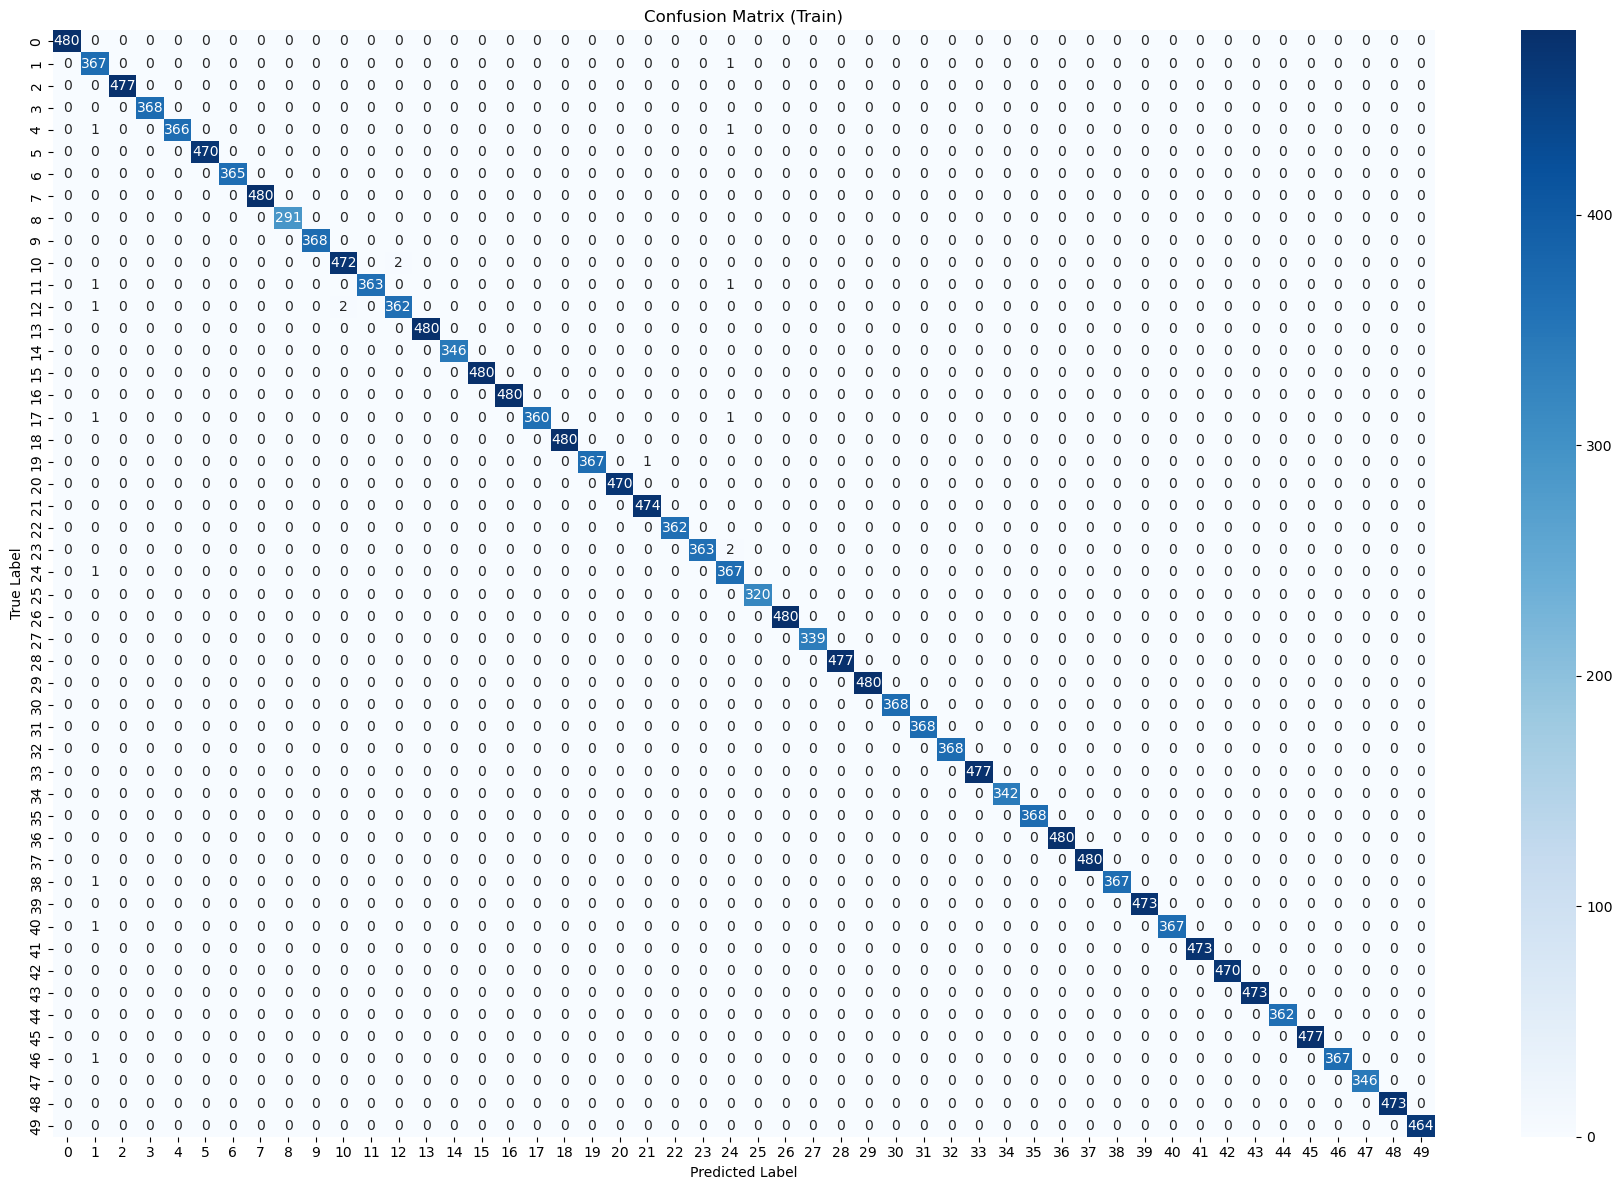

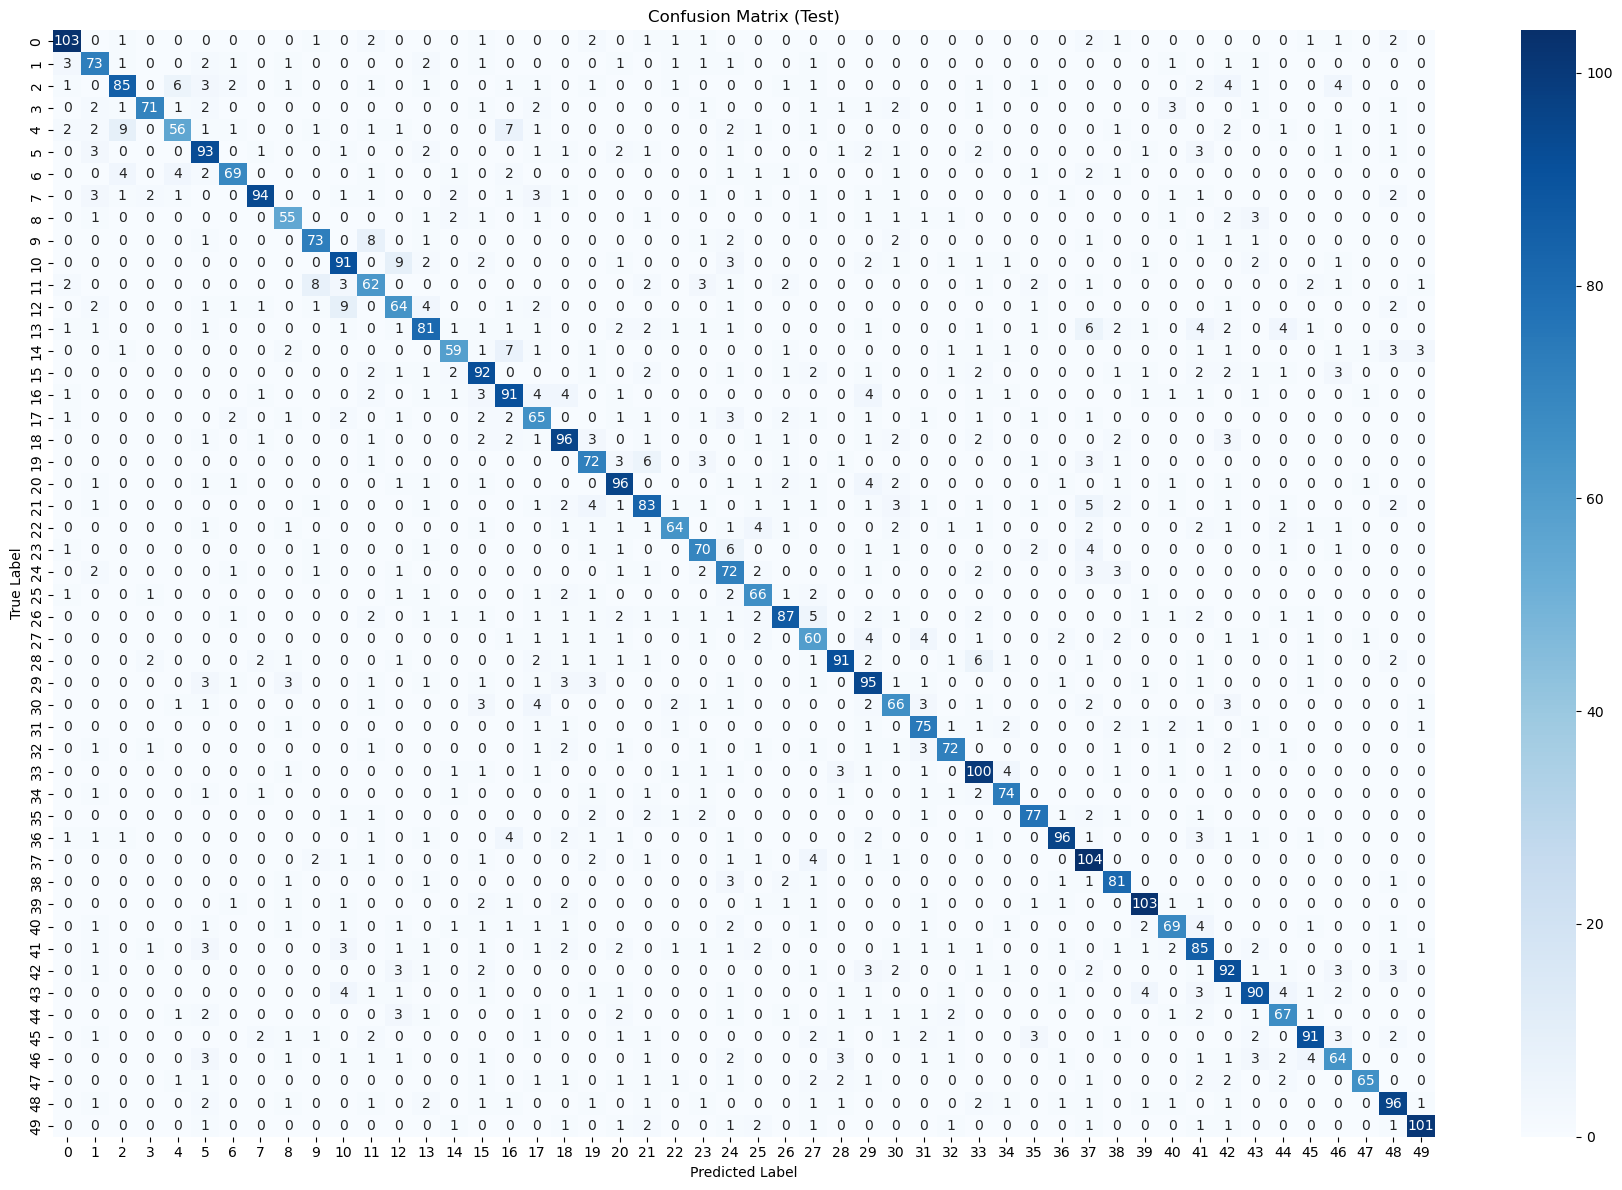

,Metric,Average Type,Train,Test
0,Training time (minutes),N/A,1.030000,N/A
1,Accuracy,N/A,0.999084,0.771026
2,Precision,macro,0.999015,0.775305
3,Precision,micro,0.999084,0.771026
4,Precision,weighted,0.999095,0.776798
5,Recall,macro,0.998987,0.769318
6,Recall,micro,0.999084,0.771026
7,Recall,weighted,0.999084,0.771026
8,F0.5-Score,macro,0.999007,0.772712
9,F0.5-Score,micro,0.999084,0.771026


In [43]:
# Predict
y_train_pred = best_hog_knn.predict(x_train_pca)
y_test_pred = best_hog_knn.predict(x_test_pca)

# Generate confusion matrix (train)
cm_train = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(18, 12))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Train)')
plt.tight_layout()
plt.show()

# Generate confusion matrix (test)
cm_train = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(18, 12))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test)')
plt.tight_layout()
plt.show()

# Function to save metrics
metrics = {"Metric": [], "Average Type": [], "Train": [], "Test": []}
def add_metric(name, avg_type, train_value, test_value):
    metrics["Metric"].append(name)
    metrics["Average Type"].append(avg_type)
    metrics["Train"].append(train_value)
    metrics["Test"].append(test_value)

# Training time
add_metric("Training time (minutes)", "N/A", training_time, "N/A")

# Accuracy
add_metric("Accuracy", "N/A",
           accuracy_score(y_train, y_train_pred),
           accuracy_score(y_test, y_test_pred))

# Precision
for avg in ['macro', 'micro', 'weighted']:
    add_metric("Precision", avg,
               precision_score(y_train, y_train_pred, average=avg),
               precision_score(y_test, y_test_pred, average=avg))

# Recall
for avg in ['macro', 'micro', 'weighted']:
    add_metric("Recall", avg,
               recall_score(y_train, y_train_pred, average=avg),
               recall_score(y_test, y_test_pred, average=avg))

# F0.5-Score 
beta = 0.5 # mis-labelled sneakers are more costly than missing labels
for avg in ['macro', 'micro', 'weighted']:
    add_metric(f"F{beta}-Score", avg,
               fbeta_score(y_train, y_train_pred, beta=beta, average=avg),
               fbeta_score(y_test, y_test_pred, beta=beta, average=avg))

# Display metrics
hog_knn_metrics = pd.DataFrame(metrics)
pd.set_option('display.precision', 6)
display(hog_knn_metrics)

In [44]:
export = False

if not export:
    print("Model not exported")
else:
    model_bank_dir = '../CS610_AML_Group_Project/model_bank'
    os.makedirs(model_bank_dir, exist_ok=True)
    model_filename_pickle = 'best_hog_knn_model.pkl'
    model_path = os.path.join(model_bank_dir, model_filename_pickle)
    with open(model_path, 'wb') as file: 
        pickle.dump(best_hog_knn, file)
    print(f"Model Saved Successfully {model_path}")

Model not exported


#### 3) XGBoostClassifier - feature extraction by hog

In [45]:
skip_train = True

if skip_train:
    # Import previous model
    print("Training skipped, importing model trained previously...")
    print("Fitted 3 folds for each of 10 candidates, totalling 30 fits")
    with open('model_bank/best_hog_xgb_model.pkl', 'rb') as file:
        best_hog_xgb = pickle.load(file)

else:

    # Start timing
    start_time = time.time()

    # Balance class weights
    sample_weights = compute_sample_weight(
        class_weight="balanced",
        y=y_train
    )

    # Base model
    base_model = xgb.XGBClassifier(
        device="cuda",
        tree_method="hist",
        objective="multi:softprob",
        num_class=len(np.unique(y_train)),
        eval_metric=['merror','mlogloss'],
        random_state=42,
    )

    # Hyperparameters
    param_dist = {
        'n_estimators': randint(50, 500),
        'max_depth': randint(3, 12),
        'learning_rate': uniform(0.01, 0.19),  # range: 0.01 to 0.2
        'subsample': uniform(0.7, 0.3),        # range: 0.7 to 1.0
        'colsample_bytree': uniform(0.7, 0.3)  # range: 0.7 to 1.0
    }

    # Randomized search tuning
    random_search = RandomizedSearchCV(
        base_model,
        param_dist,
        n_iter=10,
        scoring='accuracy',
        cv=3,
        verbose=2,
        random_state=42,
        error_score='raise',
        n_jobs=-1
    )
    random_search.fit(
        x_train_pca, y_train,
        sample_weight = sample_weights)

    # End timing
    end_time = time.time()
    training_time = end_time - start_time

Training skipped, importing model trained previously...
Fitted 3 folds for each of 10 candidates, totalling 30 fits


In [46]:
if skip_train:
    print("Training skipped, printing model trained previously...\n")
    print("Best Parameters: {'colsample_bytree': 0.7692681476866446, 'learning_rate': 0.05579483854494223, 'max_depth': 9, 'n_estimators': 477, 'subsample': 0.848553073033381}")
    print("Best Accuracy: 0.569396")
    training_time = 42.59
else:
    best_hog_xgb = random_search.best_estimator_
    print("Best Parameters:", random_search.best_params_)
    print(f"Best Accuracy: {random_search.best_score_:.6f}")
    training_time = round(training_time / 60, 2)
print(f"Total Training Time: {training_time} minutes")

Training skipped, printing model trained previously...

Best Parameters: {'colsample_bytree': 0.7692681476866446, 'learning_rate': 0.05579483854494223, 'max_depth': 9, 'n_estimators': 477, 'subsample': 0.848553073033381}
Best Accuracy: 0.569396
Total Training Time: 42.59 minutes


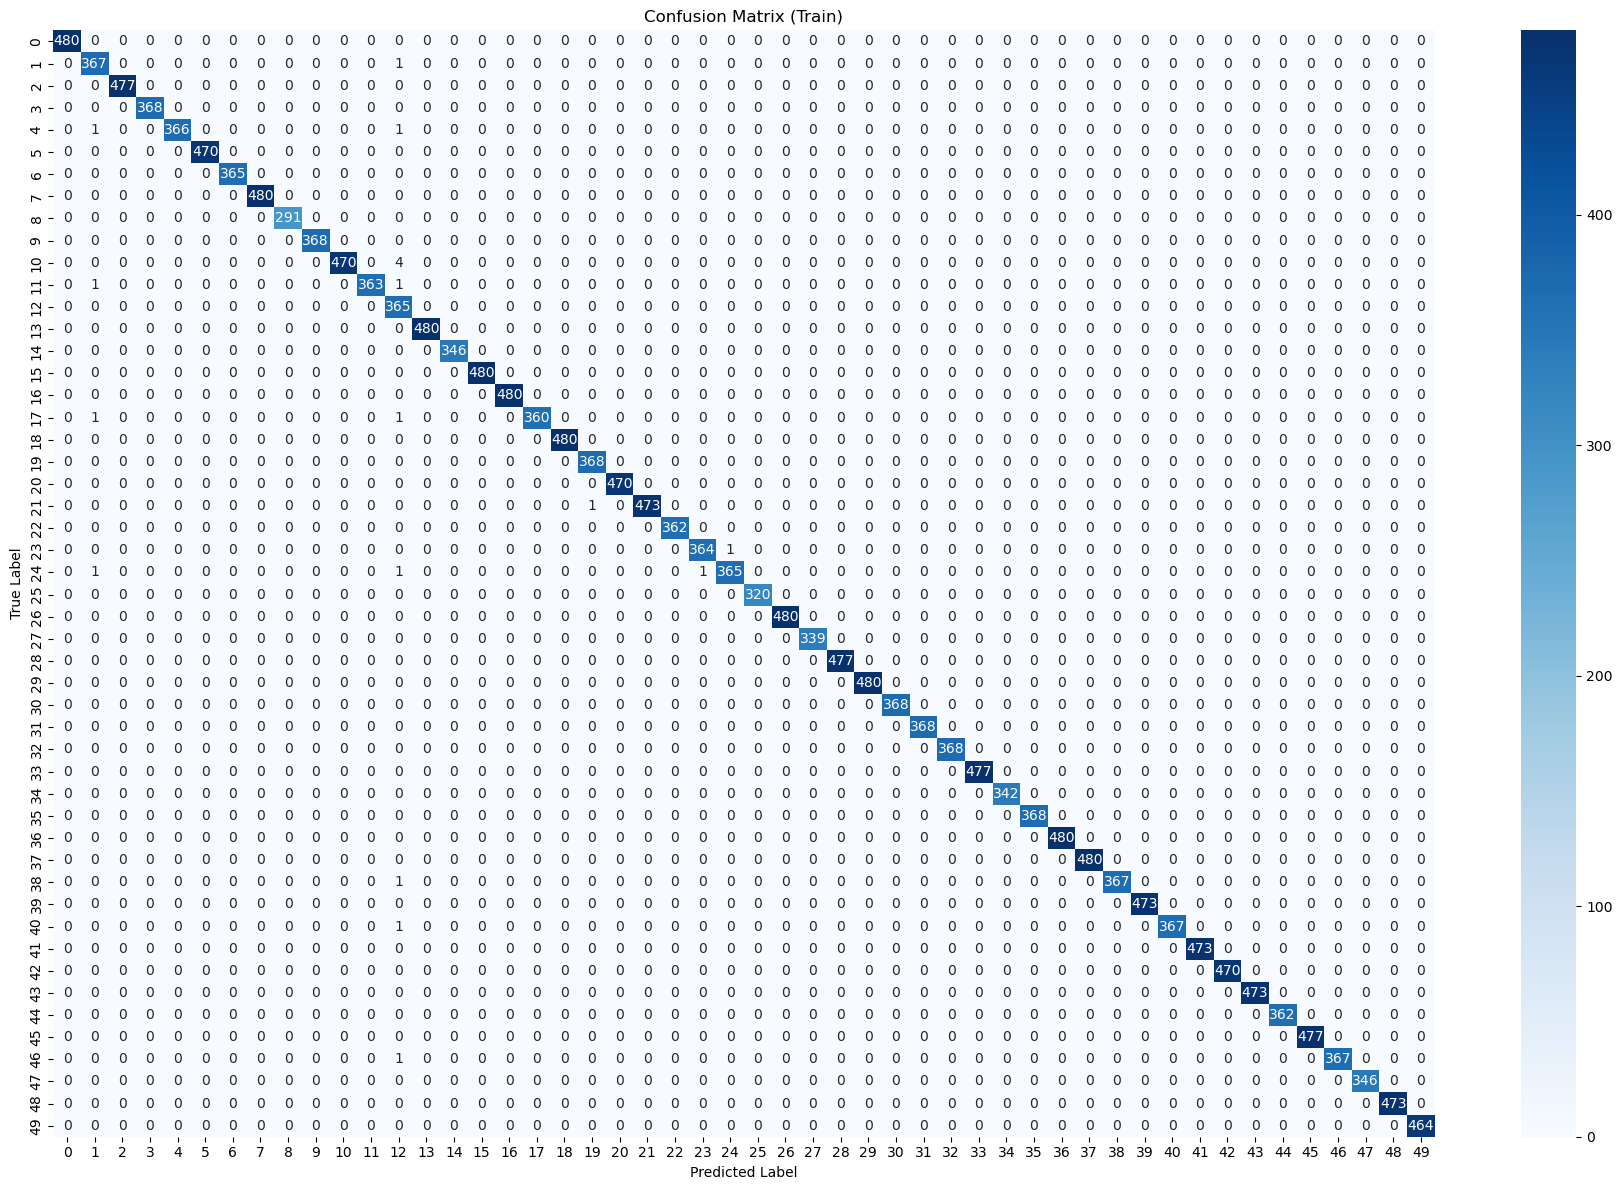

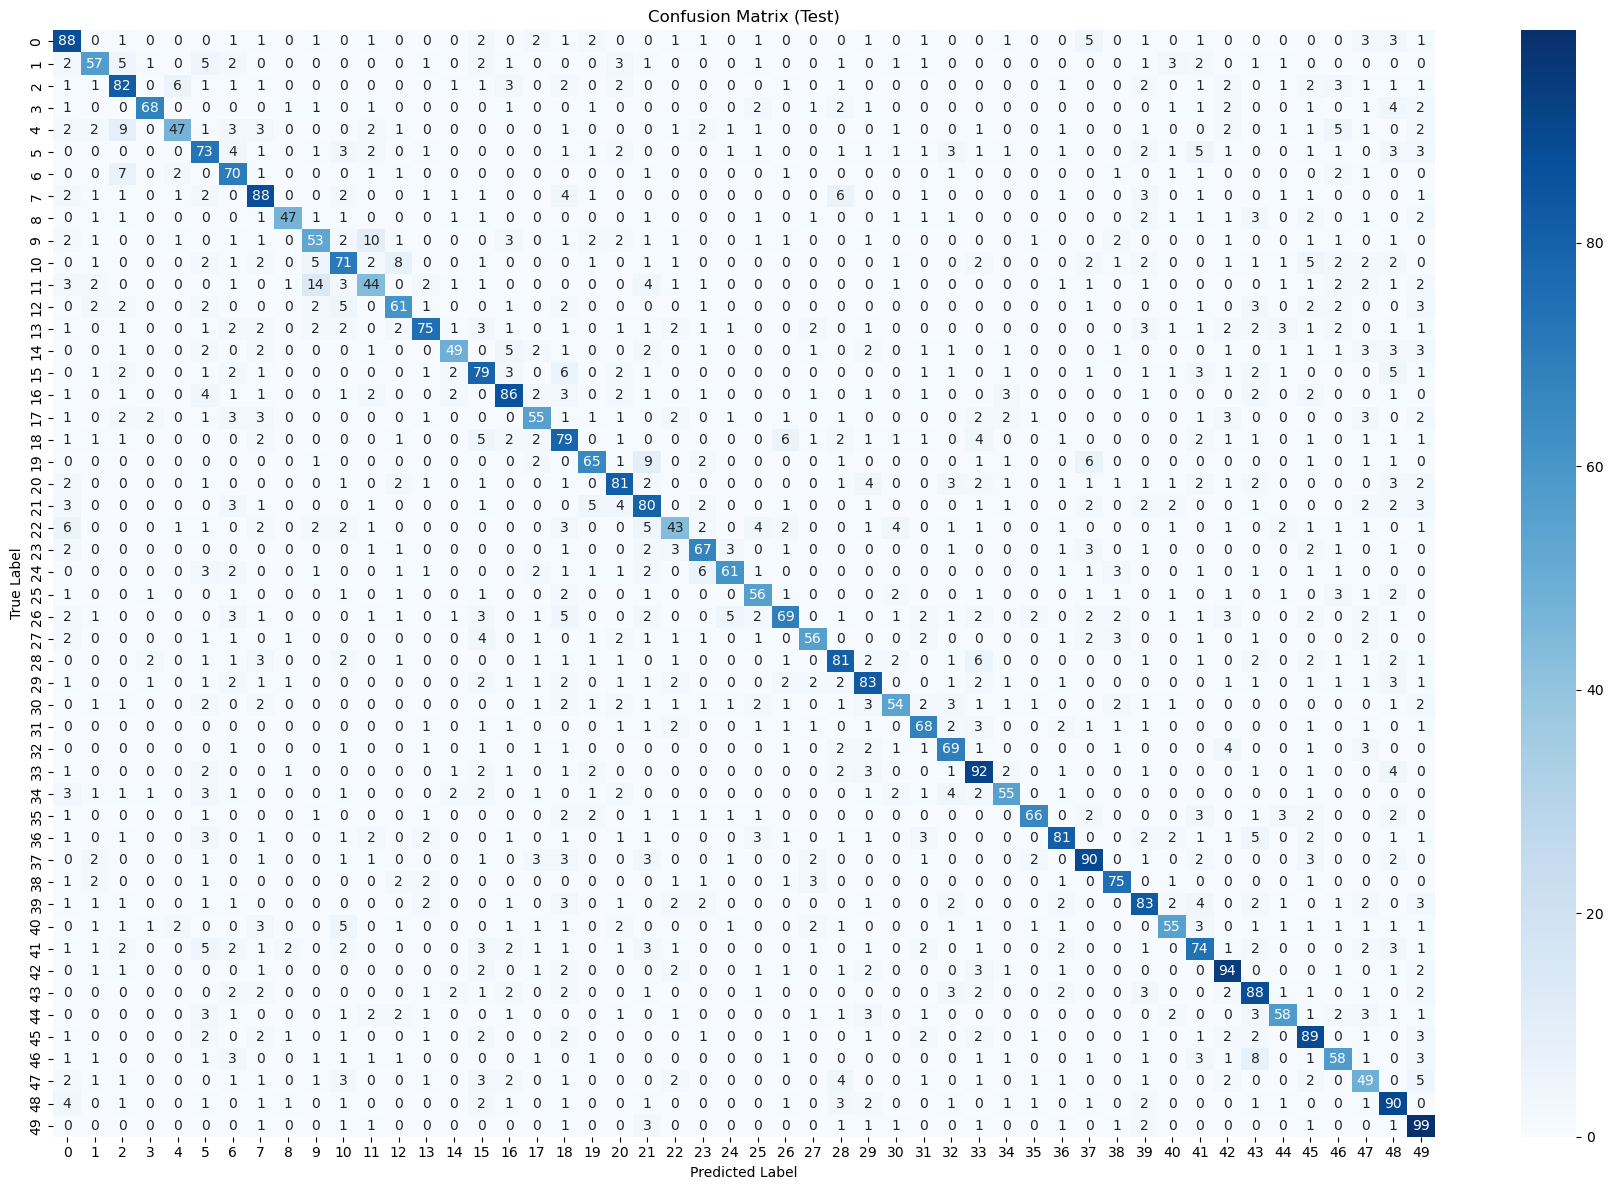

,Metric,Average Type,Train,Test
0,Training time (minutes),N/A,42.590000,N/A
1,Accuracy,N/A,0.999084,0.675347
2,Precision,macro,0.998984,0.685968
3,Precision,micro,0.999084,0.675347
4,Precision,weighted,0.999104,0.682094
5,Recall,macro,0.999025,0.671679
6,Recall,micro,0.999084,0.675347
7,Recall,weighted,0.999084,0.675347
8,F0.5-Score,macro,0.998988,0.680497
9,F0.5-Score,micro,0.999084,0.675347


In [47]:
# Predict
y_train_pred = best_hog_xgb.predict(x_train_pca)
y_test_pred = best_hog_xgb.predict(x_test_pca)

# Generate confusion matrix (train)
cm_train = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(18, 12))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Train)')
plt.tight_layout()
plt.show()

# Generate confusion matrix (test)
cm_train = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(18, 12))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test)')
plt.tight_layout()
plt.show()

# Function to save metrics
metrics = {"Metric": [], "Average Type": [], "Train": [], "Test": []}
def add_metric(name, avg_type, train_value, test_value):
    metrics["Metric"].append(name)
    metrics["Average Type"].append(avg_type)
    metrics["Train"].append(train_value)
    metrics["Test"].append(test_value)

# Training time
add_metric("Training time (minutes)", "N/A", training_time, "N/A")

# Accuracy
add_metric("Accuracy", "N/A",
           accuracy_score(y_train, y_train_pred),
           accuracy_score(y_test, y_test_pred))

# Precision
for avg in ['macro', 'micro', 'weighted']:
    add_metric("Precision", avg,
               precision_score(y_train, y_train_pred, average=avg),
               precision_score(y_test, y_test_pred, average=avg))

# Recall
for avg in ['macro', 'micro', 'weighted']:
    add_metric("Recall", avg,
               recall_score(y_train, y_train_pred, average=avg),
               recall_score(y_test, y_test_pred, average=avg))

# F0.5-Score 
beta = 0.5 # mis-labelled sneakers are more costly than missing labels
for avg in ['macro', 'micro', 'weighted']:
    add_metric(f"F{beta}-Score", avg,
               fbeta_score(y_train, y_train_pred, beta=beta, average=avg),
               fbeta_score(y_test, y_test_pred, beta=beta, average=avg))

# Display metrics
hog_xgb_metrics = pd.DataFrame(metrics)
pd.set_option('display.precision', 6)
display(hog_xgb_metrics)

In [48]:
export = False

if not export:
    print("Model not exported")
else:
    model_bank_dir = '../CS610_AML_Group_Project/model_bank'
    os.makedirs(model_bank_dir, exist_ok=True)
    model_filename_pickle = 'best_hog_xgb_model.pkl'
    model_path = os.path.join(model_bank_dir, model_filename_pickle)
    with open(model_path, 'wb') as file: 
        pickle.dump(best_hog_xgb, file)
    print(f"Model Saved Successfully {model_path}")

Model not exported


### Pipeline Models using Feature Extraction Method 2 - Using pretrained CNN

ResNet50 will be used as the feature extractor due to its pre-trained weights, derived from large datasets like ImageNet, and is a popular choice to use for computer vision applications such as image classification.
Reference:
1) https://medium.com/@meetkalathiya1301/feature-extraction-using-pre-trained-models-for-image-classification-16e6ff43f268
2) https://stackoverflow.com/questions/62117707/extract-features-from-pretrained-resnet50-in-pytorch

In [26]:
#Process image data for feature extraction using CNN
input_dir = '../CS610_AML_Group_Project/resized_images'
img_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])]) #mean and std based on ImageNet - normalise image data closer to normal distribution
img_dataset = datasets.ImageFolder(input_dir, transform=img_transform)
data_loader = DataLoader(img_dataset, batch_size=32, num_workers=4)

In [27]:
#define function for CNN feature extraction
def cnn_feature_extract(cnn_feature_extractor, data_loader):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    #prepare cnn model to use for feature extraction
    cnn_feature_extractor.eval()
    cnn_feature_extractor.fc = torch.nn.Identity() #replace fully connected layer of pretrained cnn with Identity layer
    for para in cnn_feature_extractor.parameters():
        para.requires_grad = False #freeze weights
    #feature extraction
    features_list, labels_list = [], []
    cnn_feature_extractor.to(device)
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            feature = cnn_feature_extractor(images)
            feature = feature.view(feature.size(0),-1) #flatten into (n_samples, n_features) for non-CNN models
            #convert tensors into numpy for fitting into non-CNN models and add into lists
            features_list.append(feature.cpu().numpy())
            labels_list.append(labels.numpy())

    return cnn_feature_extractor, np.vstack(features_list), np.hstack(labels_list)

In [28]:
#initialise and extract features using CNN feature extractor
weights = models.ResNet50_Weights.IMAGENET1K_V2
resnet50_extractor = models.resnet50(weights=weights)
resnet50_extractor, X, y = cnn_feature_extract(resnet50_extractor, data_loader) #X = features, y =labels
#no need labelling as the numpy array is generated from the data_loader

In [29]:
#CNN training and test split
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)
x_train = pd.DataFrame(x_train, dtype=np.float32)
y_train = pd.Series(y_train, dtype=np.int32)
x_test = pd.DataFrame(x_test, dtype=np.float32)
y_test = pd.Series(y_test, dtype=np.int32)
#same as original flow
print("Number of Samples:", len(y_train))
print("Number of Labels:", len(np.unique(y_train)))
counts = y_train.value_counts()
print("Label Distribution:")
print(counts)

Number of Samples: 20736
Number of Labels: 50
Label Distribution:
15    480
37    480
16    480
0     480
13    480
18    480
29    480
26    480
36    480
7     480
45    477
33    477
28    477
2     477
21    474
10    474
48    473
41    473
39    473
43    473
42    470
20    470
5     470
49    464
35    368
31    368
40    368
9     368
3     368
32    368
24    368
30    368
1     368
38    368
46    368
19    368
4     368
6     365
12    365
23    365
11    365
44    362
17    362
22    362
47    346
14    346
34    342
27    339
25    320
8     291
Name: count, dtype: int64


#### 1) RandomForestClassifier - feature extraction by CNN

In [49]:
skip_train = True

if skip_train:
    # Import previous model
    print("Training skipped, importing model trained previously...")
    print("Fitted 3 folds for each of 30 candidates, totalling 30 fits")
    with open('model_bank/best_cnn_rf_model.pkl', 'rb') as file:
        best_cnn_rf = pickle.load(file)

else:
    start_time = time.time()

    # Base model
    base_model = RandomForestClassifier(random_state=42)

    # Hyperparameters
    param_dist = {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [10, 20, 30, 40],
        'max_features': ['sqrt', 'log2', 0.5, 0.8, 1.0]
    }

    # Randomized search tuning
    random_search = RandomizedSearchCV(
        base_model,
        param_dist,
        n_iter=10,
        scoring='accuracy',
        cv=3,
        verbose=2,
        random_state=42,
        error_score='raise',
        n_jobs=-1
    )
    random_search.fit(x_train, y_train)

    # End timing
    end_time = time.time()
    training_time = end_time - start_time

Training skipped, importing model trained previously...
Fitted 3 folds for each of 30 candidates, totalling 30 fits


In [50]:
if skip_train:
    print("Training skipped, printing model trained previously...\n")
    print("Best Parameters: {'n_estimators': 150, 'max_features': 'sqrt', 'max_depth': 20}")
    print("Best Accuracy: 0.719473")
    training_time = 87.56
else:
    best_cnn_rf = random_search.best_estimator_
    print("Best Parameters:", random_search.best_params_)
    print(f"Best Accuracy: {random_search.best_score_:.6f}")
    training_time = round(training_time / 60, 2)
print(f"Total Training Time: {training_time} minutes")

Training skipped, printing model trained previously...

Best Parameters: {'n_estimators': 150, 'max_features': 'sqrt', 'max_depth': 20}
Best Accuracy: 0.719473
Total Training Time: 87.56 minutes


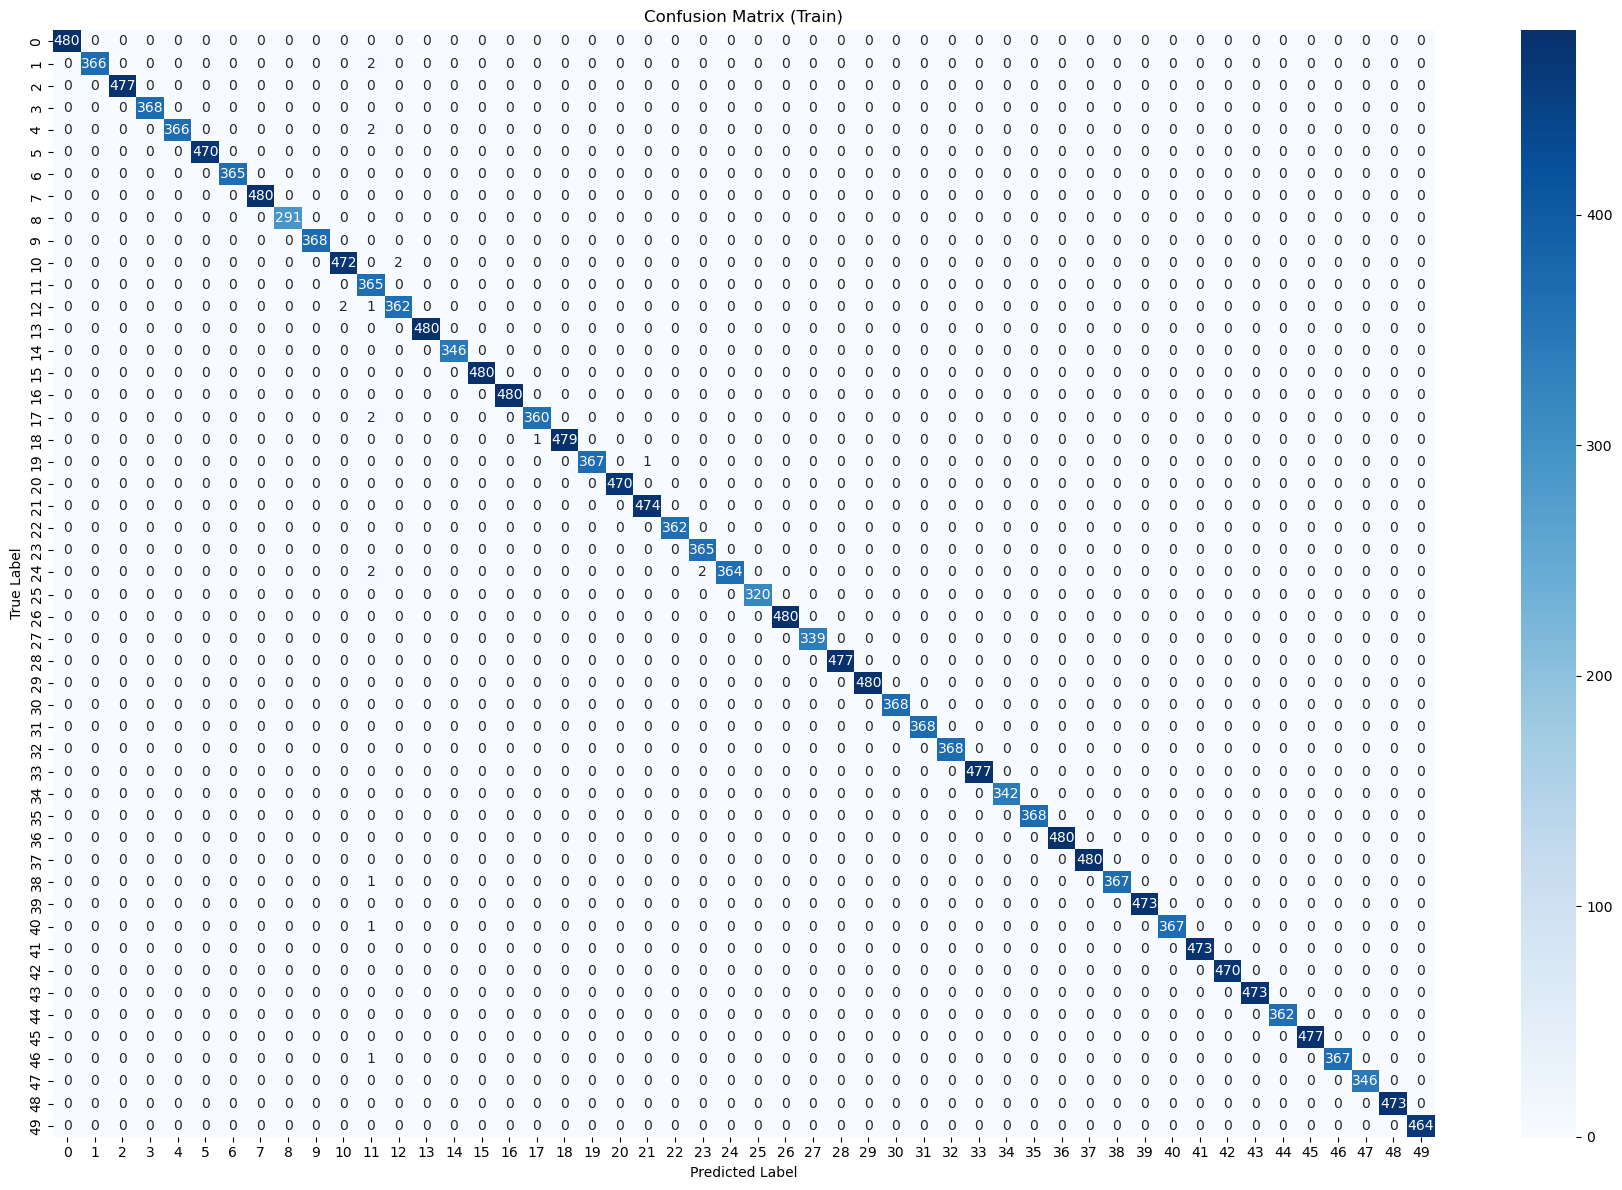

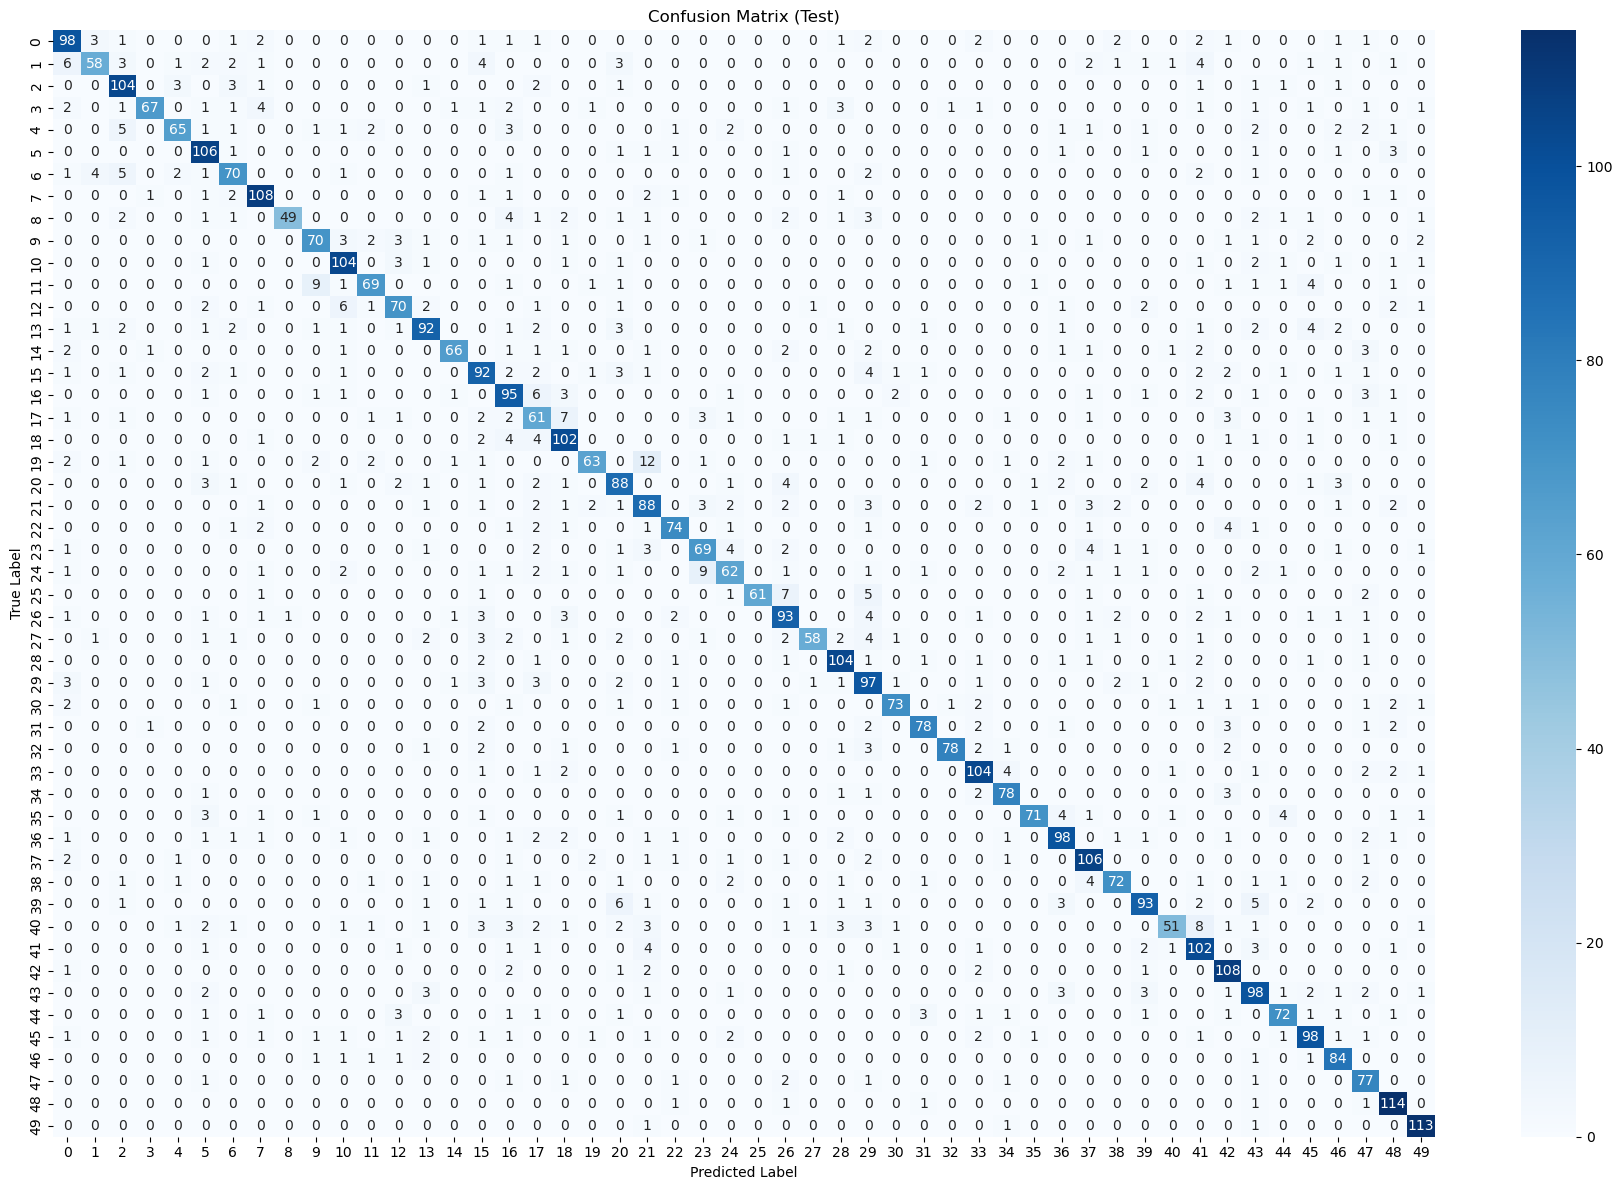

,Metric,Average Type,Train,Test
0,Training time (minutes),N/A,87.560000,N/A
1,Accuracy,N/A,0.999035,0.804591
2,Precision,macro,0.998963,0.819971
3,Precision,micro,0.999035,0.804591
4,Precision,weighted,0.999054,0.813391
5,Recall,macro,0.998947,0.798752
6,Recall,micro,0.999035,0.804591
7,Recall,weighted,0.999035,0.804591
8,F0.5-Score,macro,0.998955,0.812213
9,F0.5-Score,micro,0.999035,0.804591


In [51]:
# Predict
y_train_pred = best_cnn_rf.predict(x_train)
y_test_pred = best_cnn_rf.predict(x_test)

# Generate confusion matrix (train)
cm_train = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(18, 12))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Train)')
plt.tight_layout()
plt.show()

# Generate confusion matrix (test)
cm_train = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(18, 12))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test)')
plt.tight_layout()
plt.show()

# Function to save metrics
metrics = {"Metric": [], "Average Type": [], "Train": [], "Test": []}
def add_metric(name, avg_type, train_value, test_value):
    metrics["Metric"].append(name)
    metrics["Average Type"].append(avg_type)
    metrics["Train"].append(train_value)
    metrics["Test"].append(test_value)

# Training time
add_metric("Training time (minutes)", "N/A", training_time, "N/A")

# Accuracy
add_metric("Accuracy", "N/A",
           accuracy_score(y_train, y_train_pred),
           accuracy_score(y_test, y_test_pred))

# Precision
for avg in ['macro', 'micro', 'weighted']:
    add_metric("Precision", avg,
               precision_score(y_train, y_train_pred, average=avg),
               precision_score(y_test, y_test_pred, average=avg))

# Recall
for avg in ['macro', 'micro', 'weighted']:
    add_metric("Recall", avg,
               recall_score(y_train, y_train_pred, average=avg),
               recall_score(y_test, y_test_pred, average=avg))

# F0.5-Score 
beta = 0.5 # mis-labelled sneakers are more costly than missing labels
for avg in ['macro', 'micro', 'weighted']:
    add_metric(f"F{beta}-Score", avg,
               fbeta_score(y_train, y_train_pred, beta=beta, average=avg),
               fbeta_score(y_test, y_test_pred, beta=beta, average=avg))

# Display metrics
cnn_rf_metrics = pd.DataFrame(metrics)
pd.set_option('display.precision', 6)
display(cnn_rf_metrics)

In [52]:
export = False

if not export:
    print("Model not exported")
else:
    model_bank_dir = '../CS610_AML_Group_Project/model_bank'
    os.makedirs(model_bank_dir, exist_ok=True)
    model_filename_pickle = 'best_cnn_rf_model.pkl'
    model_path = os.path.join(model_bank_dir, model_filename_pickle)
    with open(model_path, 'wb') as file: 
        pickle.dump(best_cnn_rf, file)
    print(f"Model Saved Successfully {model_path}")

Model not exported


#### 2) KNNClassifier - feature extraction by CNN

In [53]:
skip_train = True

if skip_train:
    # Import previous model
    print("Training skipped, importing model trained previously...")
    print("Fitted 3 folds for each of 10 candidates, totalling 30 fits")
    with open('model_bank/best_cnn_knn_model.pkl', 'rb') as file:
        best_cnn_knn = pickle.load(file)

else:

    # Start timing
    start_time = time.time()

    # Base model
    base_model = KNeighborsClassifier()

    # Hyperparameters
    param_dist = {
        'n_neighbors': randint(1, 30),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'cosine']
    }

    # Randomized search tuning
    random_search = RandomizedSearchCV(
        base_model,
        param_dist,
        n_iter=10,
        scoring='accuracy',
        cv=3,
        verbose=2,
        random_state=42,
        error_score='raise',
        n_jobs=-1
    )
    random_search.fit(x_train, y_train)

    # End timing
    end_time = time.time()
    training_time = end_time - start_time

Training skipped, importing model trained previously...
Fitted 3 folds for each of 10 candidates, totalling 30 fits


In [54]:
if skip_train:
    print("Training skipped, printing model trained previously...\n")
    print("Best Parameters: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}")
    print("Best Accuracy: 0.896123")
    training_time = 3.96
else:
    best_cnn_knn = random_search.best_estimator_
    print("Best Parameters:", random_search.best_params_)
    print(f"Best Accuracy: {random_search.best_score_:.6f}")
    training_time = round(training_time / 60, 2)
print(f"Total Training Time: {training_time} minutes")

Training skipped, printing model trained previously...

Best Parameters: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}
Best Accuracy: 0.896123
Total Training Time: 3.96 minutes


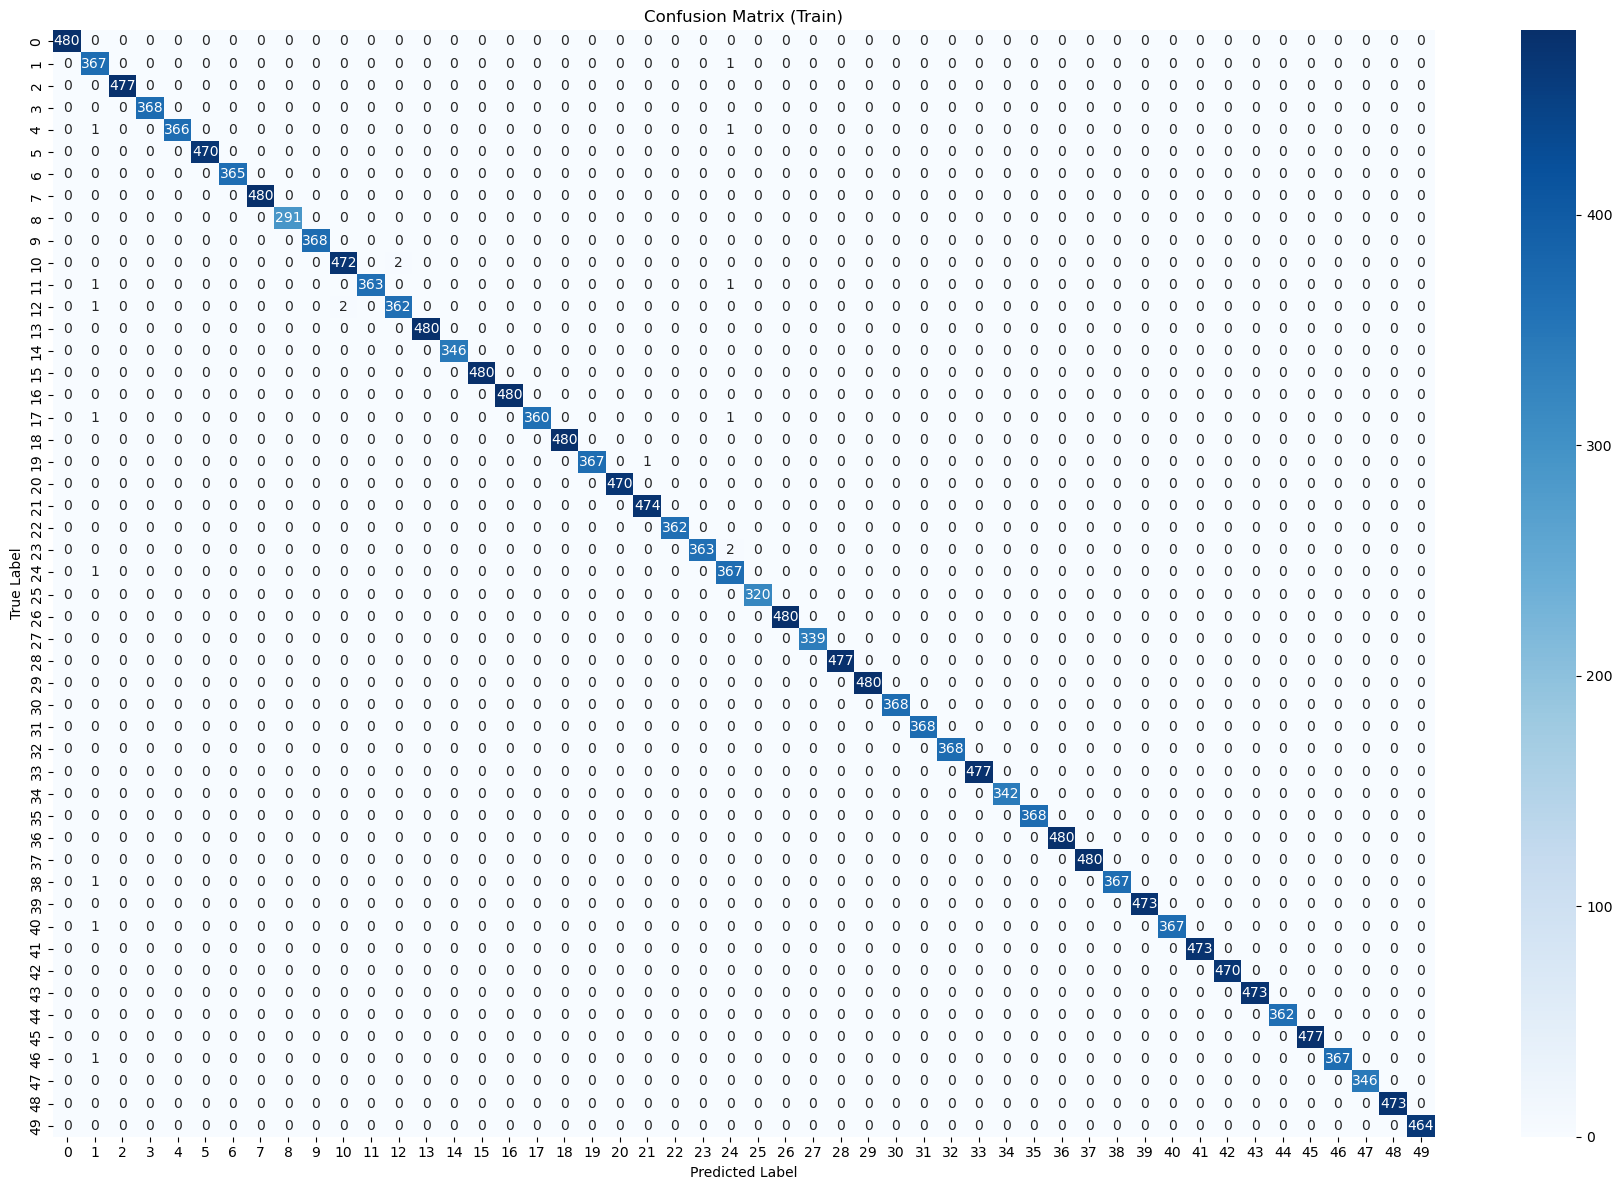

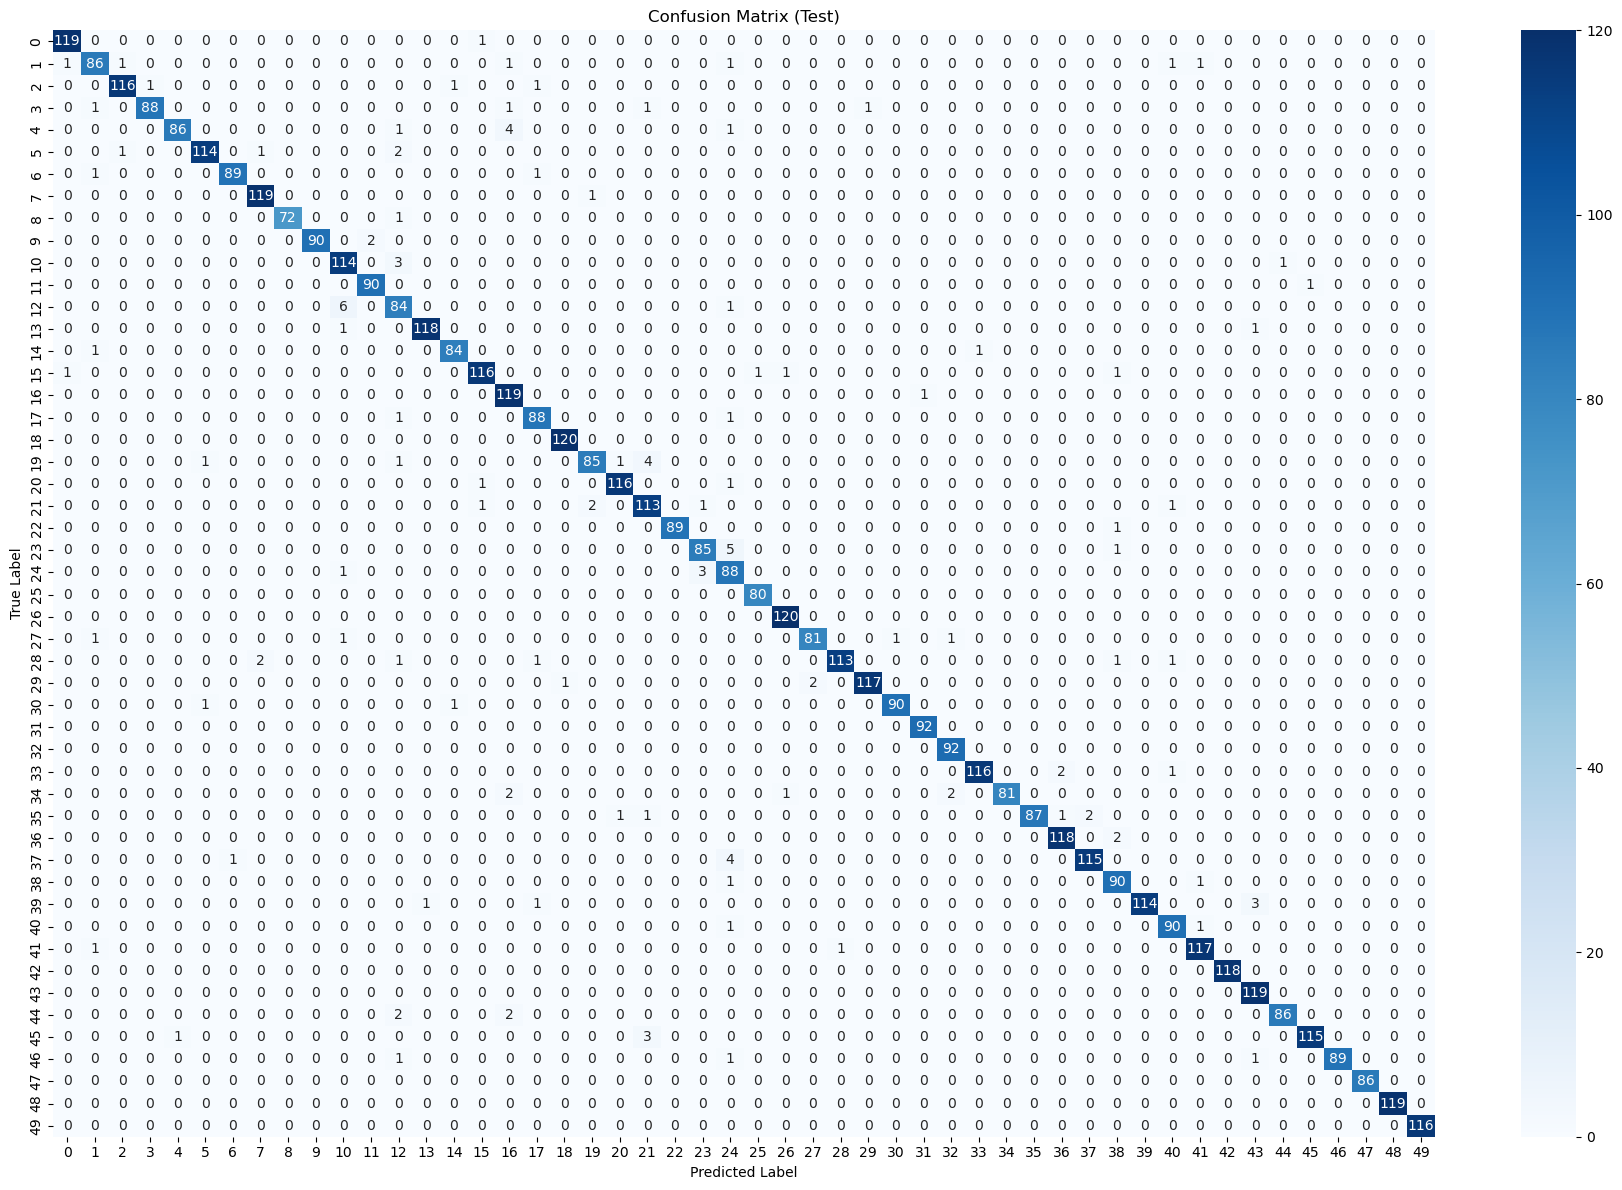

,Metric,Average Type,Train,Test
0,Training time (minutes),N/A,3.960000,N/A
1,Accuracy,N/A,0.999084,0.973958
2,Precision,macro,0.999015,0.974497
3,Precision,micro,0.999084,0.973958
4,Precision,weighted,0.999095,0.974821
5,Recall,macro,0.998987,0.973162
6,Recall,micro,0.999084,0.973958
7,Recall,weighted,0.999084,0.973958
8,F0.5-Score,macro,0.999007,0.974052
9,F0.5-Score,micro,0.999084,0.973958


In [55]:
# Predict
y_train_pred = best_cnn_knn.predict(x_train)
y_test_pred = best_cnn_knn.predict(x_test)

# Generate confusion matrix (train)
cm_train = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(18, 12))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Train)')
plt.tight_layout()
plt.show()

# Generate confusion matrix (test)
cm_train = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(18, 12))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test)')
plt.tight_layout()
plt.show()

# Function to save metrics
metrics = {"Metric": [], "Average Type": [], "Train": [], "Test": []}
def add_metric(name, avg_type, train_value, test_value):
    metrics["Metric"].append(name)
    metrics["Average Type"].append(avg_type)
    metrics["Train"].append(train_value)
    metrics["Test"].append(test_value)

# Training time
add_metric("Training time (minutes)", "N/A", training_time, "N/A")

# Accuracy
add_metric("Accuracy", "N/A",
           accuracy_score(y_train, y_train_pred),
           accuracy_score(y_test, y_test_pred))

# Precision
for avg in ['macro', 'micro', 'weighted']:
    add_metric("Precision", avg,
               precision_score(y_train, y_train_pred, average=avg),
               precision_score(y_test, y_test_pred, average=avg))

# Recall
for avg in ['macro', 'micro', 'weighted']:
    add_metric("Recall", avg,
               recall_score(y_train, y_train_pred, average=avg),
               recall_score(y_test, y_test_pred, average=avg))

# F0.5-Score 
beta = 0.5 # mis-labelled sneakers are more costly than missing labels
for avg in ['macro', 'micro', 'weighted']:
    add_metric(f"F{beta}-Score", avg,
               fbeta_score(y_train, y_train_pred, beta=beta, average=avg),
               fbeta_score(y_test, y_test_pred, beta=beta, average=avg))

# Display metrics
cnn_knn_metrics = pd.DataFrame(metrics)
pd.set_option('display.precision', 6)
display(cnn_knn_metrics)

In [56]:
export = False

if not export:
    print("Model not exported")
else:
    model_bank_dir = '../CS610_AML_Group_Project/model_bank'
    os.makedirs(model_bank_dir, exist_ok=True)
    model_filename_pickle = 'best_cnn_knn_model.pkl'
    model_path = os.path.join(model_bank_dir, model_filename_pickle)
    with open(model_path, 'wb') as file: 
        pickle.dump(best_cnn_knn, file)
    print(f"Model Saved Successfully {model_path}")

Model not exported


#### 3) XGBoostClassifier - feature extraction by CNN

In [57]:
skip_train = True

if skip_train:
    # Import previous model
    print("Training skipped, importing model trained previously...")
    print("Fitted 3 folds for each of 30 candidates, totalling 30 fits")
    with open('model_bank/best_cnn_xgb_model.pkl', 'rb') as file:
        best_cnn_xgb = pickle.load(file)

else:

    # Start timing
    start_time = time.time()

    # Balance class weights
    sample_weights = compute_sample_weight(
        class_weight="balanced",
        y=y_train
    )

    # Base model
    base_model = xgb.XGBClassifier(
        device="cuda",
        tree_method="hist",
        objective="multi:softprob",
        num_class=len(np.unique(y_train)),
        eval_metric=['merror','mlogloss'],
        random_state=42,
    )

    # Hyperparameters
    param_dist = {
        'n_estimators': randint(50, 500),
        'max_depth': randint(3, 12),
        'learning_rate': uniform(0.01, 0.19),  # range: 0.01 to 0.2
        'subsample': uniform(0.7, 0.3),        # range: 0.7 to 1.0
        'colsample_bytree': uniform(0.7, 0.3)  # range: 0.7 to 1.0
    }

    # Randomized search tuning
    random_search = RandomizedSearchCV(
        base_model,
        param_dist,
        n_iter=10,
        scoring='accuracy',
        cv=3,
        verbose=2,
        random_state=42,
        error_score='raise',
        n_jobs=-1
    )
    random_search.fit(
        x_train, y_train,
        sample_weight = sample_weights)

    # End timing
    end_time = time.time()
    training_time = end_time - start_time

Training skipped, importing model trained previously...
Fitted 3 folds for each of 30 candidates, totalling 30 fits


In [58]:
if skip_train:
    print("Training skipped, printing model trained previously...\n")
    print("Best Parameters: {'colsample_bytree': 0.7195154778955838, 'learning_rate': 0.19028825207813332, 'max_depth': 4, 'n_estimators': 314, 'subsample': 0.7047898756660642}")
    print("Best Accuracy: 0.796345")
    training_time = 216.38
else:
    best_cnn_xgb = random_search.best_estimator_
    print("Best Parameters:", random_search.best_params_)
    print(f"Best Accuracy: {random_search.best_score_:.6f}")
    training_time = round(training_time / 60, 2)
print(f"Total Training Time: {training_time} minutes")

Training skipped, printing model trained previously...

Best Parameters: {'colsample_bytree': 0.7195154778955838, 'learning_rate': 0.19028825207813332, 'max_depth': 4, 'n_estimators': 314, 'subsample': 0.7047898756660642}
Best Accuracy: 0.796345
Total Training Time: 216.38 minutes


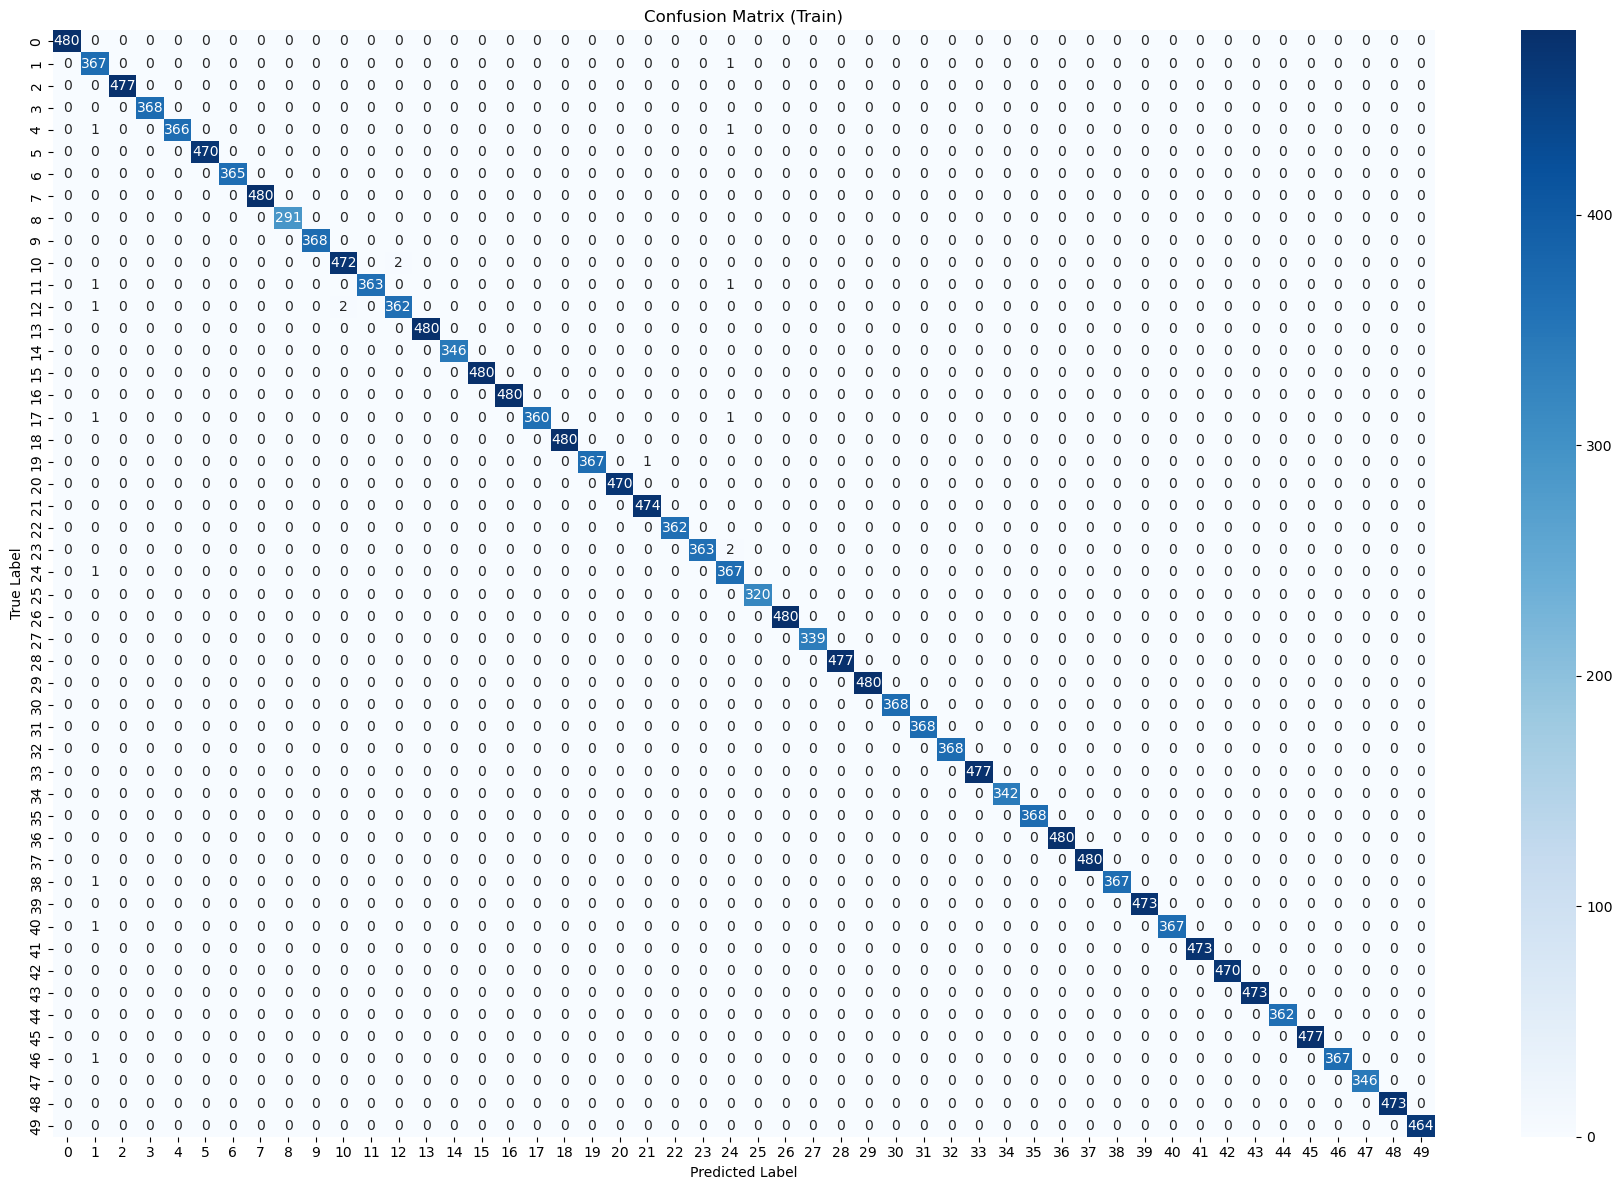

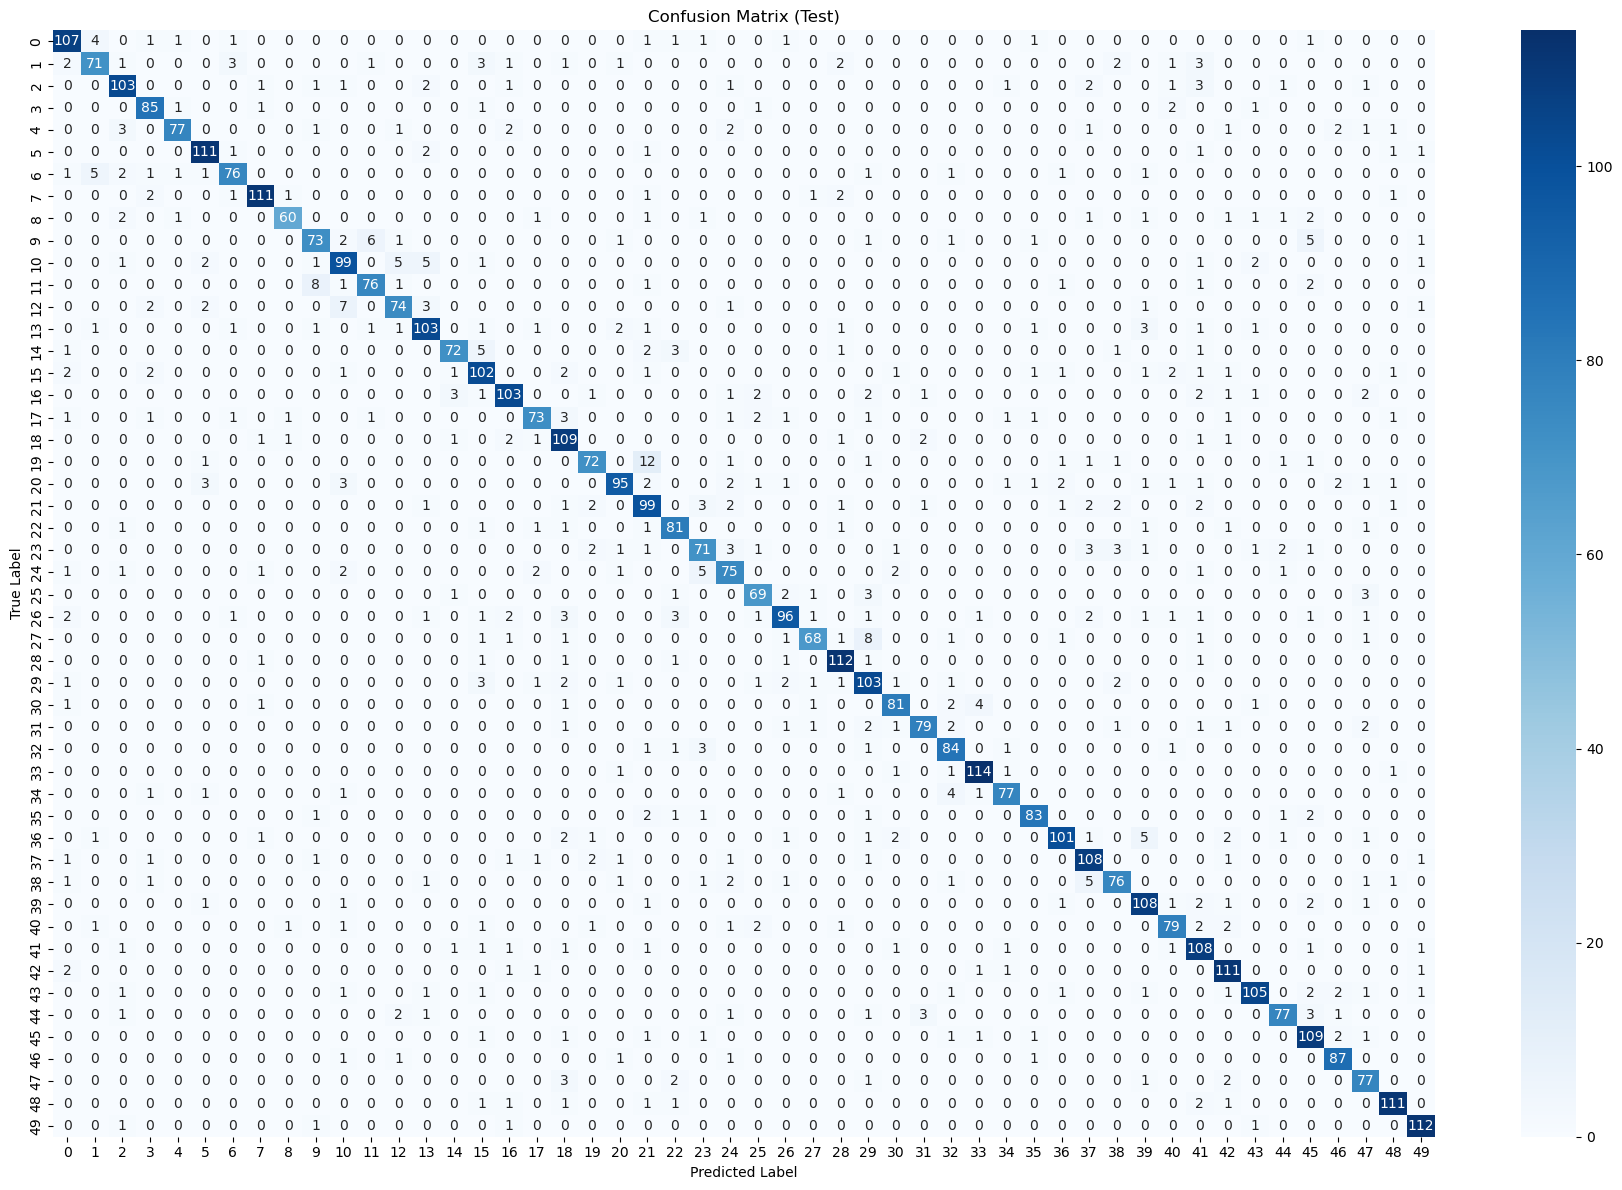

,Metric,Average Type,Train,Test
0,Training time (minutes),N/A,216.380000,N/A
1,Accuracy,N/A,0.999084,0.870563
2,Precision,macro,0.999015,0.873692
3,Precision,micro,0.999084,0.870563
4,Precision,weighted,0.999095,0.872564
5,Recall,macro,0.998987,0.867679
6,Recall,micro,0.999084,0.870563
7,Recall,weighted,0.999084,0.870563
8,F0.5-Score,macro,0.999007,0.871763
9,F0.5-Score,micro,0.999084,0.870563


In [59]:
# Predict
y_train_pred = best_cnn_xgb.predict(x_train)
y_test_pred = best_cnn_xgb.predict(x_test)

# Generate confusion matrix (train)
cm_train = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(18, 12))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Train)')
plt.tight_layout()
plt.show()

# Generate confusion matrix (test)
cm_train = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(18, 12))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test)')
plt.tight_layout()
plt.show()

# Function to save metrics
metrics = {"Metric": [], "Average Type": [], "Train": [], "Test": []}
def add_metric(name, avg_type, train_value, test_value):
    metrics["Metric"].append(name)
    metrics["Average Type"].append(avg_type)
    metrics["Train"].append(train_value)
    metrics["Test"].append(test_value)

# Training time
add_metric("Training time (minutes)", "N/A", training_time, "N/A")

# Accuracy
add_metric("Accuracy", "N/A",
           accuracy_score(y_train, y_train_pred),
           accuracy_score(y_test, y_test_pred))

# Precision
for avg in ['macro', 'micro', 'weighted']:
    add_metric("Precision", avg,
               precision_score(y_train, y_train_pred, average=avg),
               precision_score(y_test, y_test_pred, average=avg))

# Recall
for avg in ['macro', 'micro', 'weighted']:
    add_metric("Recall", avg,
               recall_score(y_train, y_train_pred, average=avg),
               recall_score(y_test, y_test_pred, average=avg))

# F0.5-Score 
beta = 0.5 # mis-labelled sneakers are more costly than missing labels
for avg in ['macro', 'micro', 'weighted']:
    add_metric(f"F{beta}-Score", avg,
               fbeta_score(y_train, y_train_pred, beta=beta, average=avg),
               fbeta_score(y_test, y_test_pred, beta=beta, average=avg))

# Display metrics
cnn_xgb_metrics = pd.DataFrame(metrics)
pd.set_option('display.precision', 6)
display(cnn_xgb_metrics)

In [60]:
export = False

if not export:
    print("Model not exported")
else:
    model_bank_dir = '../CS610_AML_Group_Project/model_bank'
    os.makedirs(model_bank_dir, exist_ok=True)
    model_filename_pickle = 'best_cnn_xgb_model.pkl'
    model_path = os.path.join(model_bank_dir, model_filename_pickle)
    with open(model_path, 'wb') as file: 
        pickle.dump(best_cnn_xgb, file)
    print(f"Model Saved Successfully {model_path}")

Model not exported


### Model Stacking

Stacking is a method that help to improve the overall performance of models as the weakness of a certain models can be compensated by the strengths of other models. Hence, we decided to utilise stacking to improve the overall performance of the model. For this technique, only the CNN-feature extraction method will be used as it has been proven to provide better model performance (in terms of accuracy).
<br>
<br>
Using the CNN extracted feature set and the models earlier in the code, they will be used in this stacking technique to determine if stacking improves the overall performance. 

#### Import the models

In [67]:
model_paths = {"rf_model":"./model_bank/best_cnn_rf_model.pkl",
               "knn_model":"./model_bank/best_cnn_knn_model.pkl",
               "xgb_model":"./model_bank/best_cnn_xgb_model.pkl"}
models = {}
for model_name, path in model_paths.items():
    print(path)
    # with open(path, "rb") as f:
    #     models[model_name] = pickle.load(f)

print(models)

./model_bank/best_cnn_rf_model.pkl
./model_bank/best_cnn_knn_model.pkl
./model_bank/best_cnn_xgb_model.pkl
{}


#### Set up stacking

In [76]:
skip_train = True

if skip_train:
    # Import previous model
    print("Training skipped, importing model trained previously...")
    with open('model_bank/stacked_model_pipeline.pkl', 'rb') as file:
        stacking_cf = pickle.load(file)
    training_time = 135.15

else:

    # Start timing
    start_time = time.time()

    # Stacked model
    estimators = [('rcf_model',RandomForestClassifier(n_estimators=150, 
                                                    max_features="sqrt", 
                                                    max_depth=20, 
                                                    random_state=42)),
                ("xgboost",xgb.XGBClassifier(colsample_bytree=0.7195154778955838, 
                                            learning_rate= 0.19028825207813332, 
                                            max_depth= 4, n_estimators= 314, 
                                            subsample=0.7047898756660642,
                                            device="cuda",
                                            tree_method="hist", 
                                            objective="multi:softprob", 
                                            num_class=len(np.unique(y_train)),
                                            eval_metric=['merror','mlogloss'],
                                            random_state=42)),
                ("knn", KNeighborsClassifier(metric= "euclidean", 
                                            n_neighbors= 1, 
                                            weights="distance"))]

    stacking_cf = StackingClassifier(estimators=estimators, 
                                    final_estimator=LogisticRegression(), 
                                    cv=3, 
                                    passthrough=False, 
                                    verbose=1)

    # Train
    start_time = time.time()
    stacking_cf.fit(x_train,y_train)

    # End timing
    end_time = time.time()
    training_time = end_time - start_time
    training_time = round(training_time / 60, 2)

print(f"Total Training Time: {training_time} minutes")

Training skipped, importing model trained previously...
Total Training Time: 135.15 minutes


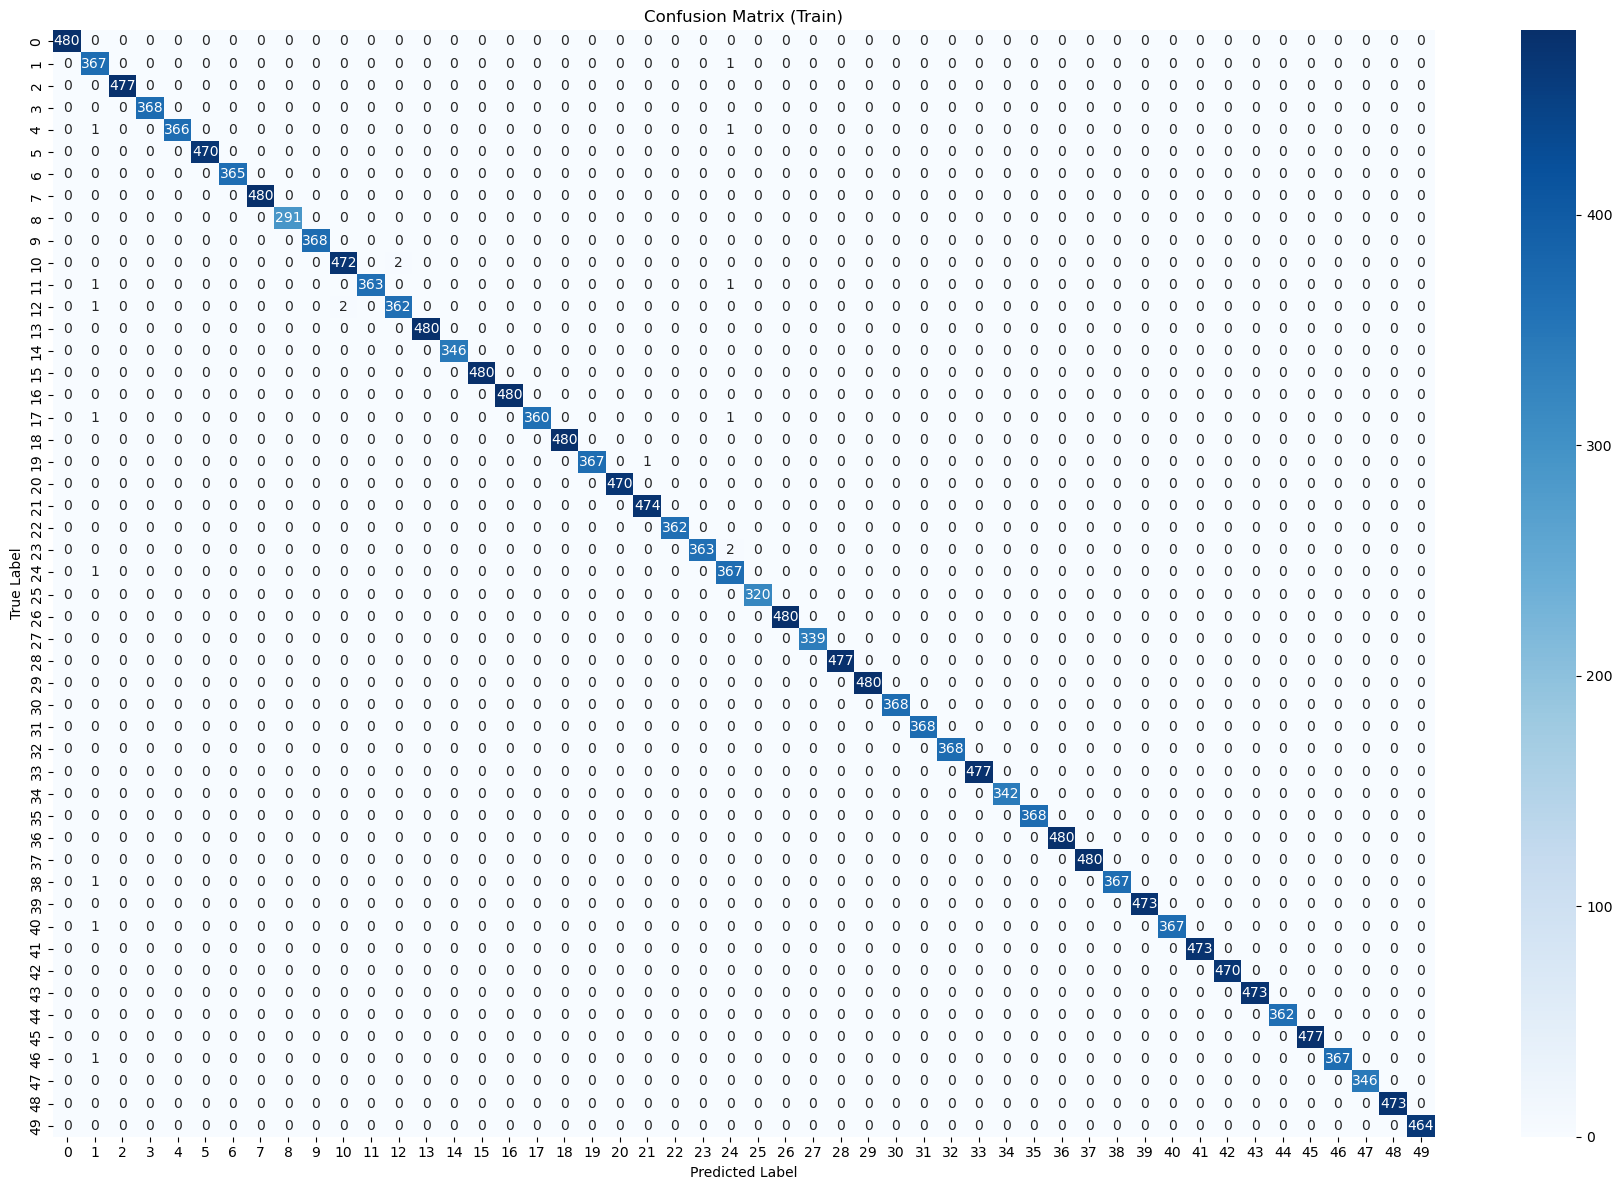

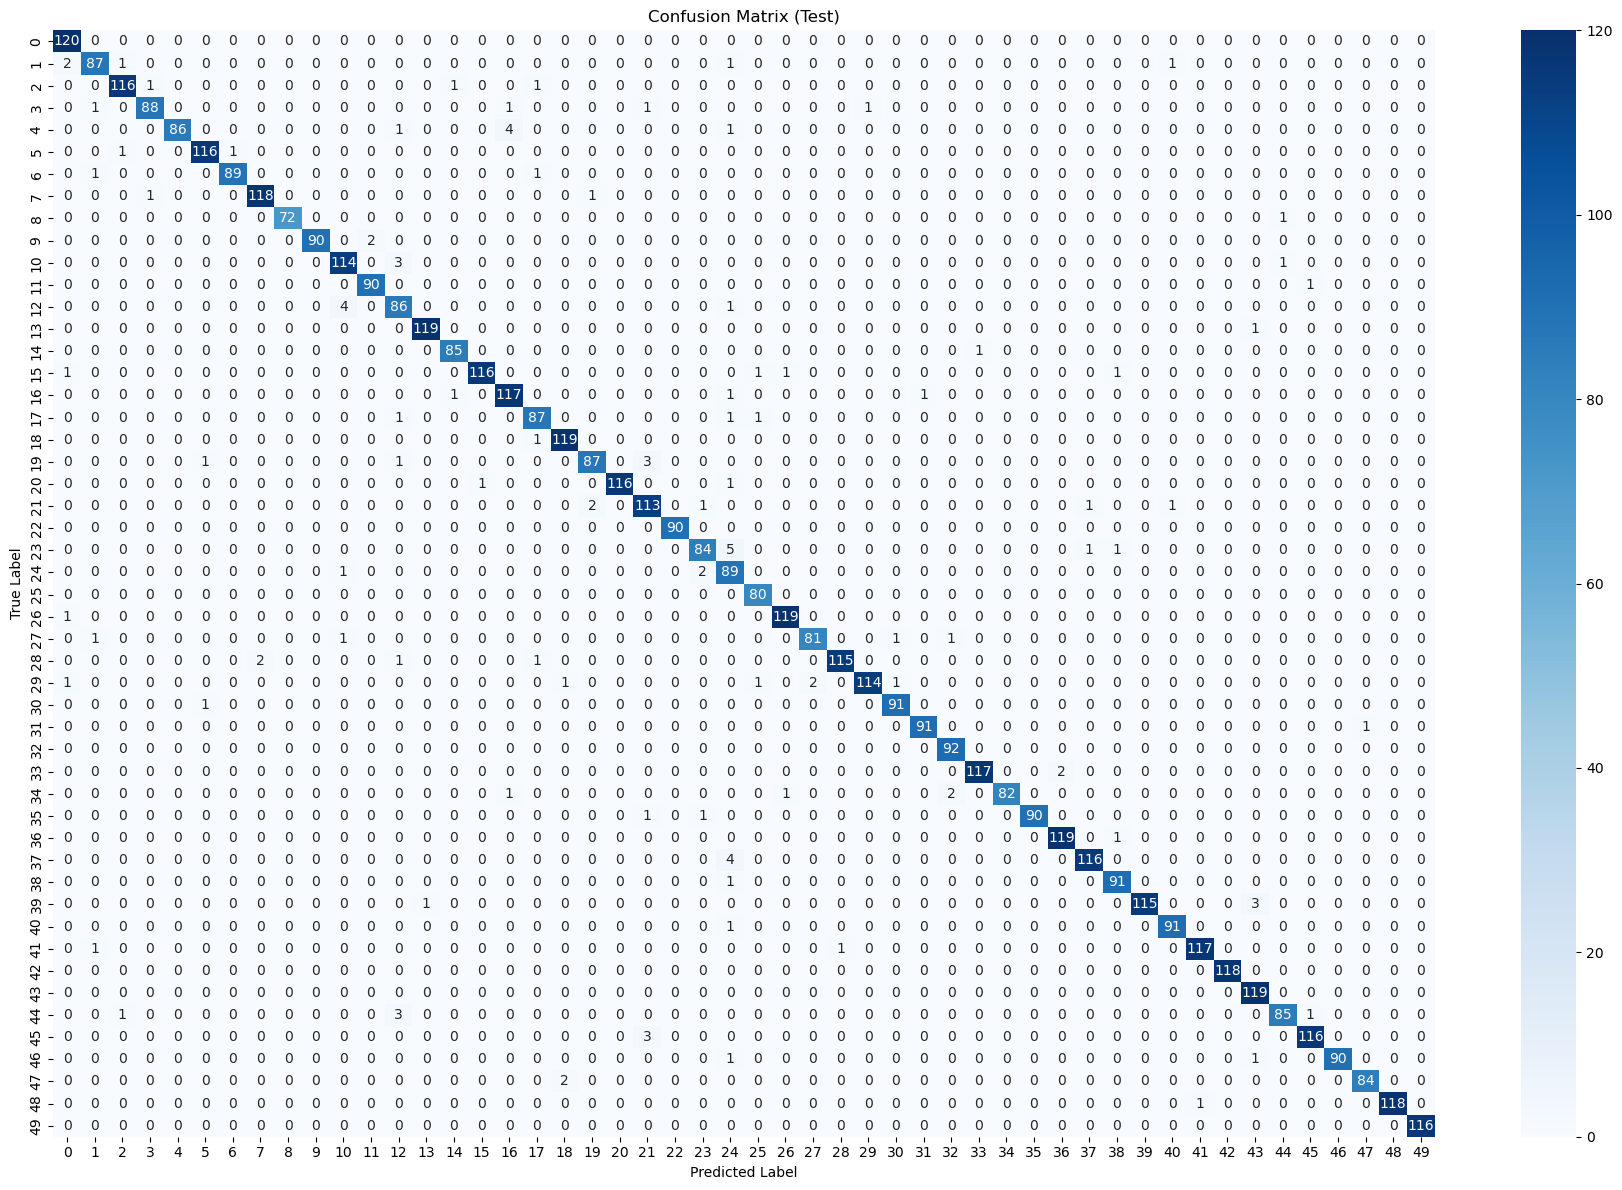

,Metric,Average Type,Train,Test
0,Training time (minutes),N/A,135.150000,N/A
1,Accuracy,N/A,0.999084,0.976273
2,Precision,macro,0.999015,0.976475
3,Precision,micro,0.999084,0.976273
4,Precision,weighted,0.999095,0.977002
5,Recall,macro,0.998987,0.975679
6,Recall,micro,0.999084,0.976273
7,Recall,weighted,0.999084,0.976273
8,F0.5-Score,macro,0.999007,0.976162
9,F0.5-Score,micro,0.999084,0.976273


In [77]:
# Predict
y_train_pred = stacking_cf.predict(x_train)
y_test_pred = stacking_cf.predict(x_test)

# Generate confusion matrix (train)
cm_train = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(18, 12))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Train)')
plt.tight_layout()
plt.show()

# Generate confusion matrix (test)
cm_train = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(18, 12))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test)')
plt.tight_layout()
plt.show()

# Function to save metrics
metrics = {"Metric": [], "Average Type": [], "Train": [], "Test": []}
def add_metric(name, avg_type, train_value, test_value):
    metrics["Metric"].append(name)
    metrics["Average Type"].append(avg_type)
    metrics["Train"].append(train_value)
    metrics["Test"].append(test_value)

# Training time
add_metric("Training time (minutes)", "N/A", training_time, "N/A")

# Accuracy
add_metric("Accuracy", "N/A",
           accuracy_score(y_train, y_train_pred),
           accuracy_score(y_test, y_test_pred))

# Precision
for avg in ['macro', 'micro', 'weighted']:
    add_metric("Precision", avg,
               precision_score(y_train, y_train_pred, average=avg),
               precision_score(y_test, y_test_pred, average=avg))

# Recall
for avg in ['macro', 'micro', 'weighted']:
    add_metric("Recall", avg,
               recall_score(y_train, y_train_pred, average=avg),
               recall_score(y_test, y_test_pred, average=avg))

# F0.5-Score 
beta = 0.5 # mis-labelled sneakers are more costly than missing labels
for avg in ['macro', 'micro', 'weighted']:
    add_metric(f"F{beta}-Score", avg,
               fbeta_score(y_train, y_train_pred, beta=beta, average=avg),
               fbeta_score(y_test, y_test_pred, beta=beta, average=avg))

# Display metrics
stack_metrics = pd.DataFrame(metrics)
pd.set_option('display.precision', 6)
display(stack_metrics)

In [79]:
export = False

if not export:
    print("Model not exported")
else:
    model_bank_dir = '../CS610_AML_Group_Project/model_bank'
    os.makedirs(model_bank_dir, exist_ok=True)
    model_filename_pickle = 'stacked_model_pipeline.pkl'
    model_path = os.path.join(model_bank_dir, model_filename_pickle)
    with open(model_path, 'wb') as file: 
        pickle.dump(stacking_cf, file)
    print(f"Model Saved Successfully {model_path}")

Model not exported


### Results Interpretation

The CNN method proved to be more beneficial in feature extraction than the usual hog feature extraction method (coupled with PCA), with all models achieving better scores on testing dataset and the models fed with hog-extracted features were showed signs of overfitting, with the test scores being much lower than the training scores.

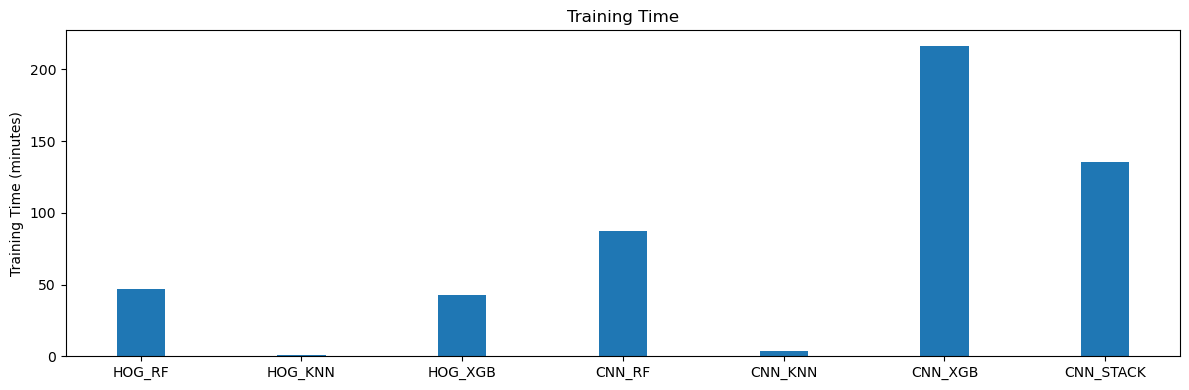

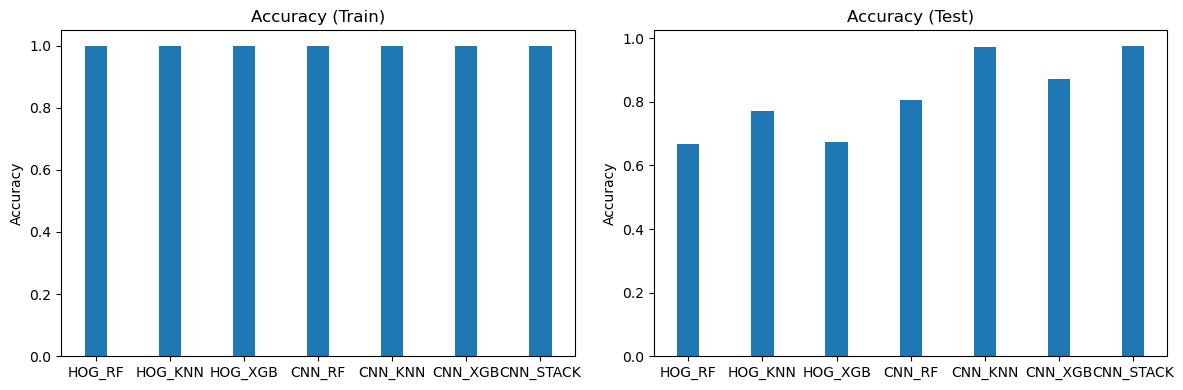

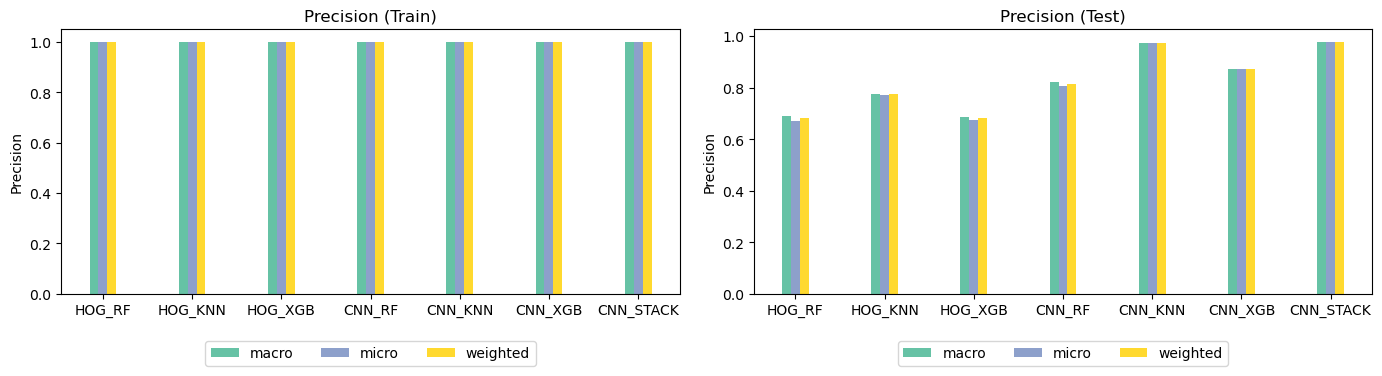

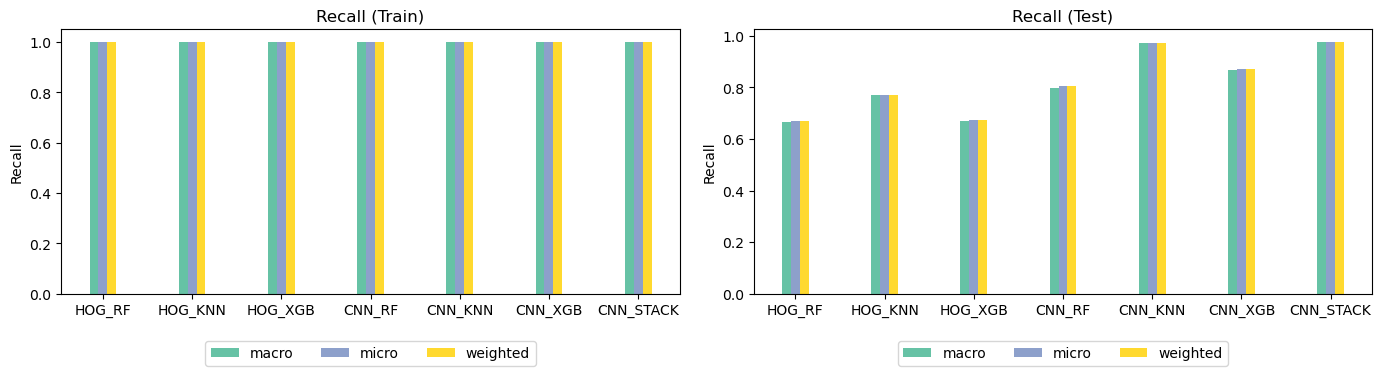

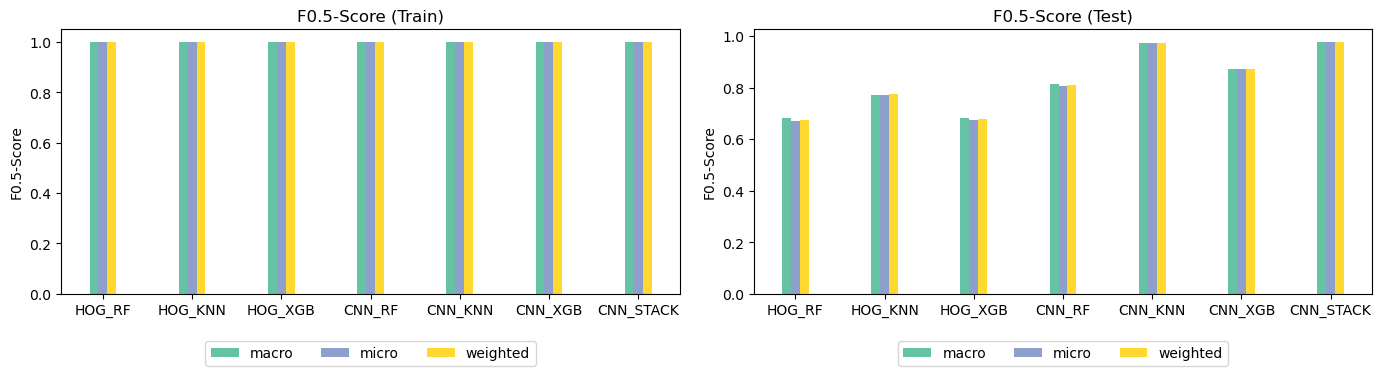

In [80]:
# Metrics table
tables = {
    'HOG_RF': hog_rf_metrics,
    'HOG_KNN': hog_knn_metrics,
    'HOG_XGB': hog_xgb_metrics,
    'CNN_RF': cnn_rf_metrics,
    'CNN_KNN': cnn_knn_metrics,
    'CNN_XGB': cnn_xgb_metrics,
    'CNN_STACK': stack_metrics
}

# Metrics to plot
metric_names = ['Training Time (minutes)', 'Accuracy', 'Precision', 'Recall', 'F0.5-Score']
precision_types = ['macro', 'micro', 'weighted']
recall_types = ['macro', 'micro', 'weighted']
f05_types = ['macro', 'micro', 'weighted']

# ----- Plot training time -----
training_times = [tables[name].loc[tables[name]['Metric'] == 'Training time (minutes)', 'Train'].values[0] for name in tables]
x = np.arange(len(tables))
bar_width = 0.1
plt.figure(figsize=(12, 4))
plt.bar(x, training_times, bar_width*3)
plt.xticks(x, tables.keys())
plt.ylabel('Training Time (minutes)')
plt.title('Training Time')
plt.tight_layout()
plt.show()

# ----- Plot accuracy -----
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Train Accuracy
train_accuracies = [tables[name].loc[tables[name]['Metric'] == 'Accuracy', 'Train'].values[0] for name in tables]
axes[0].bar(x, train_accuracies, width=bar_width*3)
axes[0].set_xticks(x)
axes[0].set_xticklabels(tables.keys())
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy (Train)')

# Test Accuracy
test_accuracies = [tables[name].loc[tables[name]['Metric'] == 'Accuracy', 'Test'].values[0] for name in tables]
axes[1].bar(x, test_accuracies, width=bar_width*3)
axes[1].set_xticks(x)
axes[1].set_xticklabels(tables.keys())
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy (Test)')
plt.tight_layout()
plt.show()

# Plot Precision, Recall, F0.5-Score
for metric, types in zip(['Precision', 'Recall', 'F0.5-Score'], [precision_types, recall_types, f05_types]):
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    for idx, data_split in enumerate(['Train', 'Test']):
        values_per_type = []
        for type_ in types:
            values = []
            for name in tables:
                df = tables[name]
                value = df.loc[
                    (df['Metric'] == metric) & (df['Average Type'] == type_),
                    data_split
                ].values[0]
                values.append(value)
            values_per_type.append(values)
        for i, values in enumerate(values_per_type):
            offset = (i - 1) * bar_width 
            axes[idx].bar(x + offset, values, width=bar_width, label=types[i], color=plt.cm.Set2(i / len(types)))
        axes[idx].set_xticks(x)
        axes[idx].set_xticklabels(tables.keys())
        axes[idx].set_ylabel(metric)
        axes[idx].set_title(f'{metric} ({data_split})')
        axes[idx].legend(ncol=3, loc='lower center', bbox_to_anchor=(0.5,-0.3))
    plt.tight_layout()
    plt.show()

### CNN model

The ResNet50 model is used to compare the performance of a Convolutional Neural Network (CNN) against non-CNNs in image classification task. It is chosen instead of deeper models as it shows comparable accuracy and F1-score, while requiring lower training time.
<br> https://www.researchgate.net/figure/Comprative-result-of-Gender-Detection-of-LFW-Dataset_tbl4_379684426

Code Reference: https://www.kaggle.com/code/nikolasgegenava/resnet18-for-sneakers-classification

#### Data Preparation

In [73]:
#Process image data for feature extraction using CNN
input_dir = '../CS610_AML_Group_Project/resized_images'
train_transform = transforms.Compose([transforms.ToTensor(),transforms.Resize((256, 256)),transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),transforms.RandomHorizontalFlip(),transforms.ColorJitter(brightness=0.1, contrast=0.1), transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])]) #mean and std based on ImageNet - normalise image data closer to normal distribution
val_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224)), transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])])
img_dataset = datasets.ImageFolder(input_dir, transform=train_transform)

train_size = int(0.7*len(img_dataset))
val_size = int(0.2*len(img_dataset))
test_size = len(img_dataset)-train_size-val_size
train_img_dataset, val_img_dataset, test_img_dataset = random_split(img_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

#swap the transform on val_img_dataset to the val_transform transformation
val_img_dataset.dataset.transform = val_transform
test_img_dataset.dataset.transform = val_transform

batch_size = 32
train_loader = DataLoader(train_img_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_img_dataset, batch_size=batch_size, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_img_dataset, batch_size=batch_size, num_workers=4, pin_memory=True)
print("Data processing done")

Data processing done


In [74]:
#get classes from directory
num_classes = len(img_dataset.classes)
print("Number of classes:", num_classes,"\n", img_dataset.classes)

Number of classes: 50 
 ['adidas_forum_high', 'adidas_forum_low', 'adidas_gazelle', 'adidas_nmd_r1', 'adidas_samba', 'adidas_stan_smith', 'adidas_superstar', 'adidas_ultraboost', 'asics_gel-lyte_iii', 'converse_chuck_70_high', 'converse_chuck_70_low', 'converse_chuck_taylor_all-star_high', 'converse_chuck_taylor_all-star_low', 'converse_one_star', 'new_balance_327', 'new_balance_550', 'new_balance_574', 'new_balance_990', 'new_balance_992', 'nike_air_force_1_high', 'nike_air_force_1_low', 'nike_air_force_1_mid', 'nike_air_jordan_11', 'nike_air_jordan_1_high', 'nike_air_jordan_1_low', 'nike_air_jordan_3', 'nike_air_jordan_4', 'nike_air_max_1', 'nike_air_max_270', 'nike_air_max_90', 'nike_air_max_95', 'nike_air_max_97', 'nike_air_max_plus_(tn)', 'nike_air_vapormax_flyknit', 'nike_air_vapormax_plus', 'nike_blazer_mid_77', 'nike_cortez', 'nike_dunk_high', 'nike_dunk_low', 'puma_suede_classic', 'reebok_classic_leather', 'reebok_club_c_85', 'salomon_xt-6', 'vans_authentic', 'vans_old_skool',

#### Model Training
<i>Comparison between our self made model and pretrained model(?)

In [75]:
#check if cuda is available to use
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device, "is used")

cuda is used


In [87]:
#Initialise and setup pre-trained model
weights = models.ResNet50_Weights.IMAGENET1K_V2 # IMAGENET1K_V2 used as it has shown to improve the performance of ResNet50
cnn_model = models.resnet50(weights=weights)
for parameter in cnn_model.parameters():
    parameter.requires_grad = False #freeze gradient of pretrained layers to save pretrained feature training

#Replace fully connected layer with new nn.Linear to allow it to be trained on our dataset
cnn_model.fc = nn.Linear(cnn_model.fc.in_features, num_classes)
#switch to gpu if available
cnn_model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [88]:
#Set up Loss and Optimiser
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(cnn_model.fc.parameters(), lr=1e-3)

In [ ]:
#set up training and validation loop
beta = 0.5  # mis-labelled sneakers are more costly than missing labels
best_val_acc = 0
best_val_epoch = float('inf')
train_metrics, val_metrics = {}, {}
early_stopper = 0 #counter for early stopping
threshold = 3 #early_stopping threshold
for epoch in range(100):
    print(f"-----------------------------------------\nTraining results of Epoch {epoch+1}\n-----------------------------------------")
    train_holder = {}
    train_holder['y_true'], train_holder['y_hat'] = [], []
    cnn_model.train()
    running_loss, running_corrects = 0.0, 0
    for i, data in enumerate(train_loader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        optimiser.zero_grad()
        outputs = cnn_model(images)
        _, train_preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step()
        running_loss    += loss.item() * images.size(0)
        running_corrects+= (train_preds == labels).sum().item()
        train_holder['y_true'].extend(list(labels.cpu().detach().numpy()))
        train_holder['y_hat'].extend(list(train_preds.cpu().detach().numpy()))

    train_y_true_all = train_holder['y_true']
    train_y_pred_all = train_holder['y_hat']
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc  = running_corrects / len(train_loader.dataset)
    train_precision = precision_score(train_y_true_all, train_y_pred_all, average='macro')
    train_recall = recall_score(train_y_true_all, train_y_pred_all, average='macro')
    train_fbeta = fbeta_score(train_y_true_all, train_y_pred_all, beta=beta, average='macro')

    print("Epoch %d, Epoch loss: %.3f, Epoch accuracy: %.3f"%(epoch+1, epoch_loss, epoch_acc))

    print(f"-----------------------------------------\nValidation results of Epoch {epoch+1}\n-----------------------------------------")
    val_holder = {}
    val_holder['y_true'], val_holder['y_hat'] = [], []
    cnn_model.eval()
    val_loss, val_corrects = 0.0, 0
    with torch.no_grad():
        for data in val_loader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)

                outputs = cnn_model(images)
                _, val_preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                val_corrects+= (val_preds == labels).sum().item()
                val_holder['y_true'].extend(list(labels.cpu().detach().numpy()))
                val_holder['y_hat'].extend(list(val_preds.cpu().detach().numpy()))

        val_y_true_all = val_holder['y_true']
        val_y_pred_all = val_holder['y_hat']
        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc  = val_corrects / len(val_loader.dataset)
        val_precision = precision_score(val_y_true_all, val_y_pred_all, average='macro')
        val_recall = recall_score(val_y_true_all, val_y_pred_all, average='macro')
        val_fbeta = fbeta_score(val_y_true_all, val_y_pred_all, beta=beta, average='macro')
        val_class_report = classification_report(val_y_true_all, val_y_pred_all)

        print("Validation loss: %.3f, Validation accuracy: %.3f"%(val_epoch_loss, val_epoch_acc))    
        if val_epoch_acc > best_val_acc and val_epoch_loss < best_val_epoch: 
            early_stopper = 0
            best_val_acc, best_val_epoch = val_epoch_acc, val_epoch_loss
            train_metrics["accuracy"], train_metrics["precision"], train_metrics["recall"], train_metrics["f_beta"] = epoch_acc, train_precision, train_recall, train_fbeta
            val_metrics["accuracy"], val_metrics["precision"], val_metrics["recall"], val_metrics["f_beta"], val_metrics["classification_report"] = val_epoch_acc, val_precision, val_recall, val_fbeta, val_class_report
            torch.save(cnn_model.state_dict(), "./model_bank/best_resnet50.pth")
            print("Model saved as 'best_resnet50.pth'")
        
        if val_epoch_acc < best_val_acc: #early stop loop if model performance does not improve for 3 epoch iterations - prevent overfitting and waste of resources
             early_stopper += 1
             if early_stopper == threshold:
                print("Model stopping")
                break
        
        

-----------------------------------------
Training results of Epoch 1
-----------------------------------------
Epoch 1, Epoch loss: 2.871, Epoch accuracy: 0.362
-----------------------------------------
Validation results of Epoch 1
-----------------------------------------
Validation loss: 2.170, Validation accuracy: 0.518
Model saved as 'best_resnet50.pth'
-----------------------------------------
Training results of Epoch 2
-----------------------------------------
Epoch 2, Epoch loss: 1.867, Epoch accuracy: 0.601
-----------------------------------------
Validation results of Epoch 2
-----------------------------------------
Validation loss: 1.688, Validation accuracy: 0.613
Model saved as 'best_resnet50.pth'
-----------------------------------------
Training results of Epoch 3
-----------------------------------------
Epoch 3, Epoch loss: 1.446, Epoch accuracy: 0.694
-----------------------------------------
Validation results of Epoch 3
-----------------------------------------


Based on the results, the performance of the model did not improve and showed signs of overfitting after the 29th iteration of training (as the validation accuracy decreased while the training accuracy increased)

#### Model Evaluation

In [96]:
#load best cnn_model
best_model = torch.load("./model_bank/best_resnet50.pth")
cnn_model.load_state_dict(best_model)
#create dictionary to store metrics
test_holder = {}
test_holder['y_true'], test_holder['y_hat'] = [], []
#start evaluation of model
cnn_model.eval()
test_corrects = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        output = cnn_model(images)
        _, test_preds = torch.max(output, 1)
        test_corrects += (test_preds == labels).sum().item()
        test_holder['y_true'].extend(list(labels.cpu().detach().numpy()))
        test_holder['y_hat'].extend(list(test_preds.cpu().detach().numpy()))


test_y_true_all = test_holder['y_true']
test_y_pred_all = test_holder['y_hat']
test_acc = test_corrects / len(test_loader.dataset)
test_precision = precision_score(test_y_true_all, test_y_pred_all, average='macro')
test_recall = recall_score(test_y_true_all, test_y_pred_all, average='macro')
test_fbeta = fbeta_score(test_y_true_all, test_y_pred_all, beta=beta, average='macro')
test_class_report = classification_report(test_y_true_all, test_y_pred_all)

In [102]:
# --- Train Scores ---
print("------------------------------------\nTRAIN METRICS\n------------------------------------")
print("Accuracy:", round(train_metrics["accuracy"],3))
print("Precision (macro):", round(train_metrics["precision"],3))
print("Recall (macro):", round(train_metrics["recall"],3))
print(f"F{beta}-Score (macro):", round(train_metrics["f_beta"],3))
print("\n"*2)
# --- Validation Scores ---
print("------------------------------------\nVALIDATION METRICS\n------------------------------------")
print("Accuracy:", round(val_metrics["accuracy"],3))
print("Precision (macro):", round(val_metrics["precision"],3))
print("Recall (macro):", round(val_metrics["recall"],3))
print(f"F{beta}-Score (macro):", round(val_metrics["f_beta"],3))
print("Classification_Report:\n", val_metrics["classification_report"])
print("\n"*2)
# --- Test Scores ---
print("------------------------------------\nTEST METRICS\n------------------------------------")
print("Accuracy:", round(test_acc,3))
print("Precision (macro):", round(test_precision,3))
print("Recall (macro):", round(test_recall,3))
print(f"F{beta}-Score (macro):", round(test_fbeta,3))
print("Classification_Report:\n", test_class_report)

------------------------------------
TRAIN METRICS
------------------------------------
Accuracy: 0.966
Precision (macro): 0.966
Recall (macro): 0.966
F0.5-Score (macro): 0.966



------------------------------------
VALIDATION METRICS
------------------------------------
Accuracy: 0.87
Precision (macro): 0.872
Recall (macro): 0.869
F0.5-Score (macro): 0.87
Classification_Report:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89       107
           1       0.84      0.88      0.86        88
           2       0.95      0.76      0.84       114
           3       0.94      0.83      0.88        78
           4       0.85      0.92      0.88        95
           5       0.81      0.86      0.83       116
           6       0.81      0.80      0.81        81
           7       0.88      0.92      0.90       106
           8       0.86      0.82      0.84        68
           9       0.89      0.90      0.89        94
          10       0.